In [1]:
import pylab as plt
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
%matplotlib inline

from sbmtm import sbmtm
import graph_tool.all as gt

# Load data

In [11]:
input_df=pd.read_csv('./Data/data_with_charlson.csv')
input_df_no_outcomes=input_df.drop(['Unnamed: 0','age_score','oasis','mortality','ICUSTAY_ID','subject_id','admission_age','charlson_comorbidity_index','sepsis','mortality','diagnosis','icustay_id','sofa'],axis=1)
input_df_no_outcomes.set_index('hadm_id',inplace=True)
print('Data correctly loaded. There are {} unique admissions.'.format(len(input_df)))

Data correctly loaded. There are 38417 unique admissions.


In [12]:
input_df_no_outcomes

myocardial_infarct  congestive_heart_failure  \
hadm_id                                                 
163557                    0                         0   
129310                    1                         0   
129607                    0                         0   
177527                    0                         0   
127229                    1                         1   
...                     ...                       ...   
186679                    0                         0   
169431                    0                         0   
134959                    0                         0   
158288                    0                         0   
129161                    0                         0   

         peripheral_vascular_disease  cerebrovascular_disease  dementia  \
hadm_id                                                                   
163557                             0                        0         0   
129310                             0                        0         0   
129607                             0                        0         0   
177527                             0                        0         0   
127229                             1                        0         0   
...                              ...                      ...       ...   
186679                             0                        0         0   
169431                             0                        0         0   
134959                             0                        0         0   
158288                             0                        0         0   
129161                             0                        0         0   

         chronic_pulmonary_disease  rheumatic_disease  peptic_ulcer_disease  \
hadm_id                                                                       
163557                           0                  0                     0   
129310                           0                  0                     0   
129607                           0                  0                     0   
177527                           0                  0                     0   
127229                           1                  0                     0   
...                            ...                ...                   ...   
186679                           0                  0                     0   
169431                           0                  0                     0   
134959                           0                  0                     0   
158288                           0                  0                     0   
129161                           0                  0                     0   

         mild_liver_disease  diabetes_without_cc  ...  aids  16-24  25-44  \
hadm_id                                           ...                       
163557                    0                    0  ...     0      0      0   
129310                    0                    0  ...     0      0      1   
129607                    0                    0  ...     0      0      0   
177527                    0                    0  ...     0      0      1   
127229                    0                    0  ...     0      0      0   
...                     ...                  ...  ...   ...    ...    ...   
186679                    0                    0  ...     0      0      1   
169431                    0                    0  ...     0      0      1   
134959                    0                    0  ...     0      1      0   
158288                    0                    1  ...     0      0      0   
129161                    0                    0  ...     0      0      0   

         45-64  65-84  over85  F  M  ELECTIVE  NON_ELECTIVE  
hadm_id                                                      
163557       1      0       0  0  1         0             1  
129310       0      0       0  0  1         0             1  
129607       

# Build network

First, we populate the lists of patients and their features.

In [13]:
patient_df=pd.DataFrame(np.where(input_df_no_outcomes.eq(1), input_df_no_outcomes.columns, input_df_no_outcomes), 
                  index=input_df_no_outcomes.index, 
                  columns=input_df_no_outcomes.columns)
pat_features = [[t for t in patient if t != 0] for patient in patient_df.values.tolist()]
admission_id = [h.split()[0] for h in patient_df.index.values.astype('str')]

Then, we build the network.

In [14]:
model = sbmtm()
model.make_graph(pat_features,documents=admission_id,counts=False)
model.g

<Graph object, undirected, with 38443 vertices and 178031 edges, 2 internal vertex properties, at 0x7ff069328a00>

# Model fitting
We fit the model initially by using the minimize blockmodel algorithm. Then, we further improve this fit by using the mcmc multiflip algorithm, as suggested in the 2020 paper that introduced it.

In [23]:
SEED=50
gt.seed_rng(SEED) ## seed for graph-tool's random number generator --> same results
model.fit(n_init=100)
print('The lowest entropy was {}, and the state has {} blocks at level 0'.format(model.state.entropy(),model.state.get_levels()[0].get_nonempty_B()))
with open('./Results/minimized_model_seed_{}.pkl'.format(SEED),'wb') as f:
    pickle.dump(model,f)

378790.51407980546
390988.22939868167
377994.3311956512
378704.34911044524
378548.3547046982
380616.3330076543
380378.0490081014
391897.8666775869
390822.88528135774
377620.3644740006
391897.8666775869
380599.11592749273
375890.87422801234
390390.316922629
380623.7188025634
385588.5971105769
378705.44671366713
387551.60855342547
378538.97736438457
380485.12732972176
384499.13127972424
378642.38615863613
391897.8666775869
389526.9771293798
388914.2660098784
375600.08975390025
390390.21470975137
391897.8666775869
380581.33170893695
391897.8666775869
378662.38199384947
390158.19765246176
378155.01730026683
380531.90140303865
391897.8666775869
384407.34576230525
379513.5029670215
391897.8666775869
384641.81445581245
386680.6746890026
391897.8666775869
389507.4998492114
386791.8004549497
378071.3945810076
391897.8666775869
384625.8164413511
388156.7284290728
387734.0308460779
380598.89204053755
388361.68602788623
390421.2276626516
380613.2274728363
377884.1798288392
384343.68839782843
39189

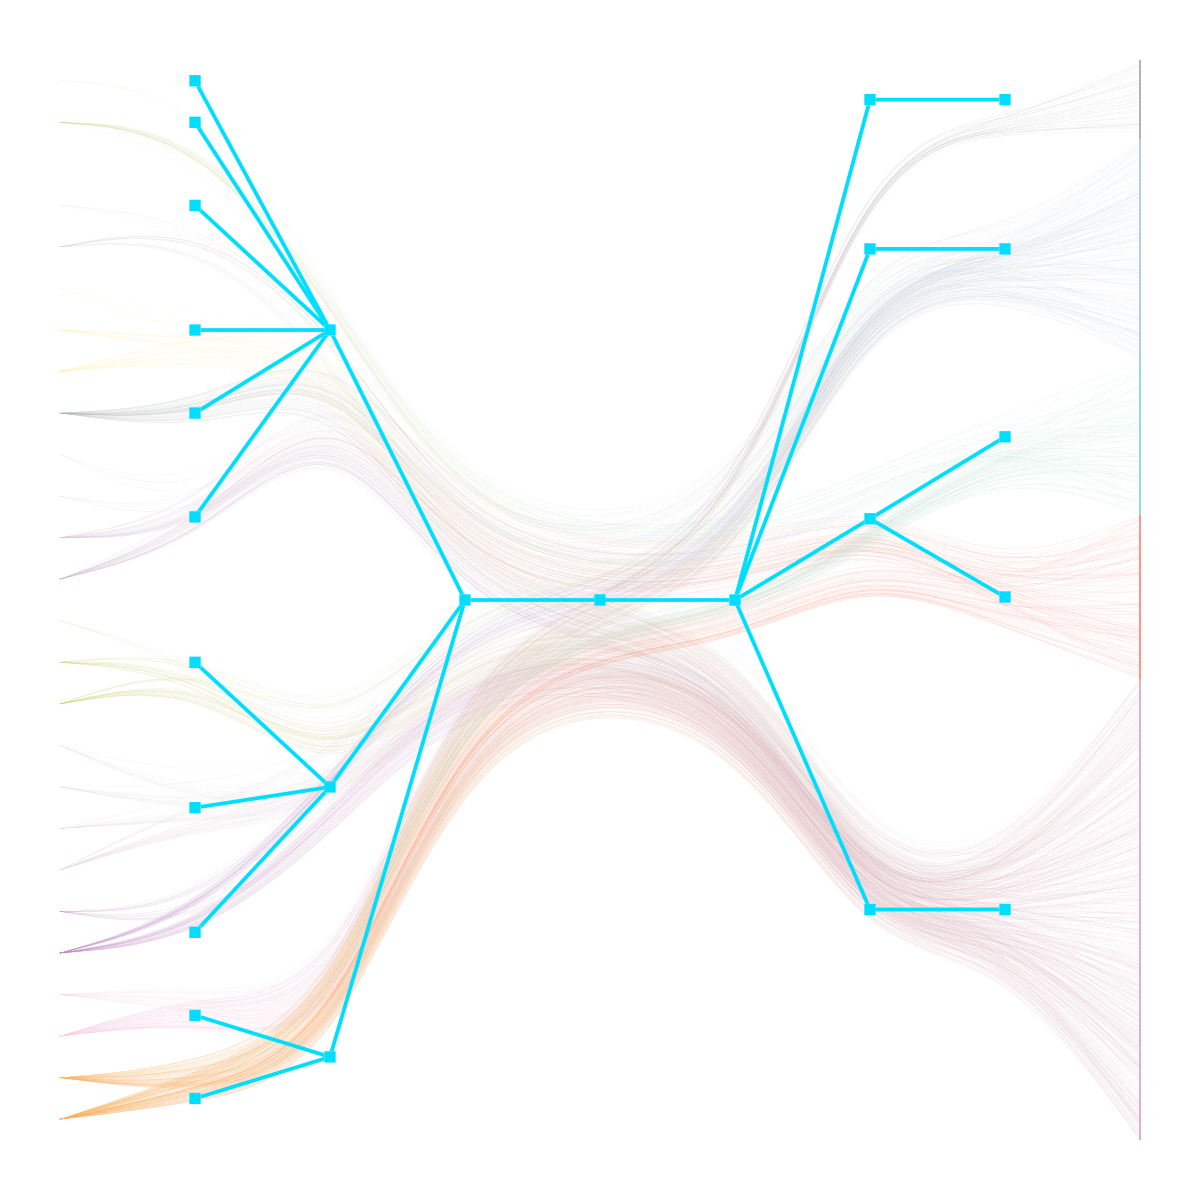

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7ff069328a00, at 0x7ff0682dbf70>,
 <Graph object, directed, with 38469 vertices and 38468 edges, at 0x7ff06914b580>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7ff06914b580, at 0x7ff069163c70>)

In [24]:
model.state.draw(subsample_edges=1000,layout='bipartite',bip_aspect=1,
           hvertex_size=8, hedge_pen_width=1.9, hedge_color="#00deff", hvertex_fill_color="#00DEFF", output_size=(600, 600))

## Model obtained with 100 runs, seed 50

In [26]:
with open("./Results/minimized_model_seed_{}.pkl".format(SEED), "rb") as f:
        model_100 = pickle.load(f)
print('This state has {} blocks at level 0, {} at level 1, and its entropy is entropy: {:.2f}'.format(model_100.state.get_levels()[0].get_nonempty_B(),model_100.state.get_levels()[1].get_nonempty_B(),model_100.state.entropy()))

This state has 16 blocks at level 0, 7 at level 1, and its entropy is entropy: 375600.09


Here we do a further sweep with the multiflip_mcmc just in case we got stuck in a bad local minimum.

In [27]:
starting_entropy=model_100.state.entropy()
entropy_gain_multiflip=[model_100.state.multiflip_mcmc_sweep(beta=np.inf, niter=10)[0] for i in range(1000)]

### Compute the likelihood difference based on the entropy changes above

The first step is to compute the entropy difference between the initial entropy and the new one. We obtain this by computing the cumulative sum of entropy_gain_multiflip. This difference represents the natural logarithm of posterior odds ratio between the new state and the initial one.

Since we have the natural logarithm of the posterior odds ratio, we can easily compute the actual ratio now.

In [29]:
entropy_diff = np.cumsum(np.array(entropy_gain_multiflip))
entropy_diff_positive = -entropy_diff
entropy_exp_10 = entropy_diff_positive/(np.log(2)+np.log(5))
entropy_likelihood = np.power(10,entropy_exp_10)

/tmp/ipykernel_3506149/481641675.py:4: RuntimeWarning: overflow encountered in power
  entropy_likelihood = np.power(10,entropy_exp_10)


In [ ]:
with open('./Results/entropy_likelihood.pkl','wb') as f:
    pickle.dump(entropy_likelyhood,f)

In [36]:
with open('./Results/multiflip_mcmc_model_seed_{}.pkl'.format(SEED),'wb') as f:
    pickle.dump(model_100,f)

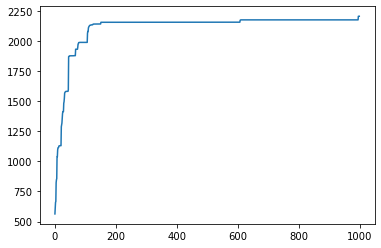

In [30]:
plt.plot(entropy_exp_10)

In [4]:
# LOAD THE LIKELIHOOD ARRAY
with open('./Results/entropy_likelihood.pkl','rb') as f:
    entropy_likelihood = pickle.load(f)

In [282]:
with open('./Results/final_model_AI4Health.pkl','wb') as f:
    pickle.dump(model_100,f)
with open('./Results/entropy_likelihood.pkl','wb') as f:
    pickle.dump(entropy_likelihood,f)

In [10]:
# LOAD THE MODEL
with open('./Results/final_model_AI4Health.pkl','rb') as f:
    model = pickle.load(f)

/usr/local/Caskroom/miniconda/base/envs/gt/lib/python3.9/site-packages/graph_tool/inference/blockmodel.py:387: UserWarning: unrecognized keyword arguments: ['sampling']
  warnings.warn("unrecognized keyword arguments: " +


We plot the new state we obtained after running the multiflip mcmc

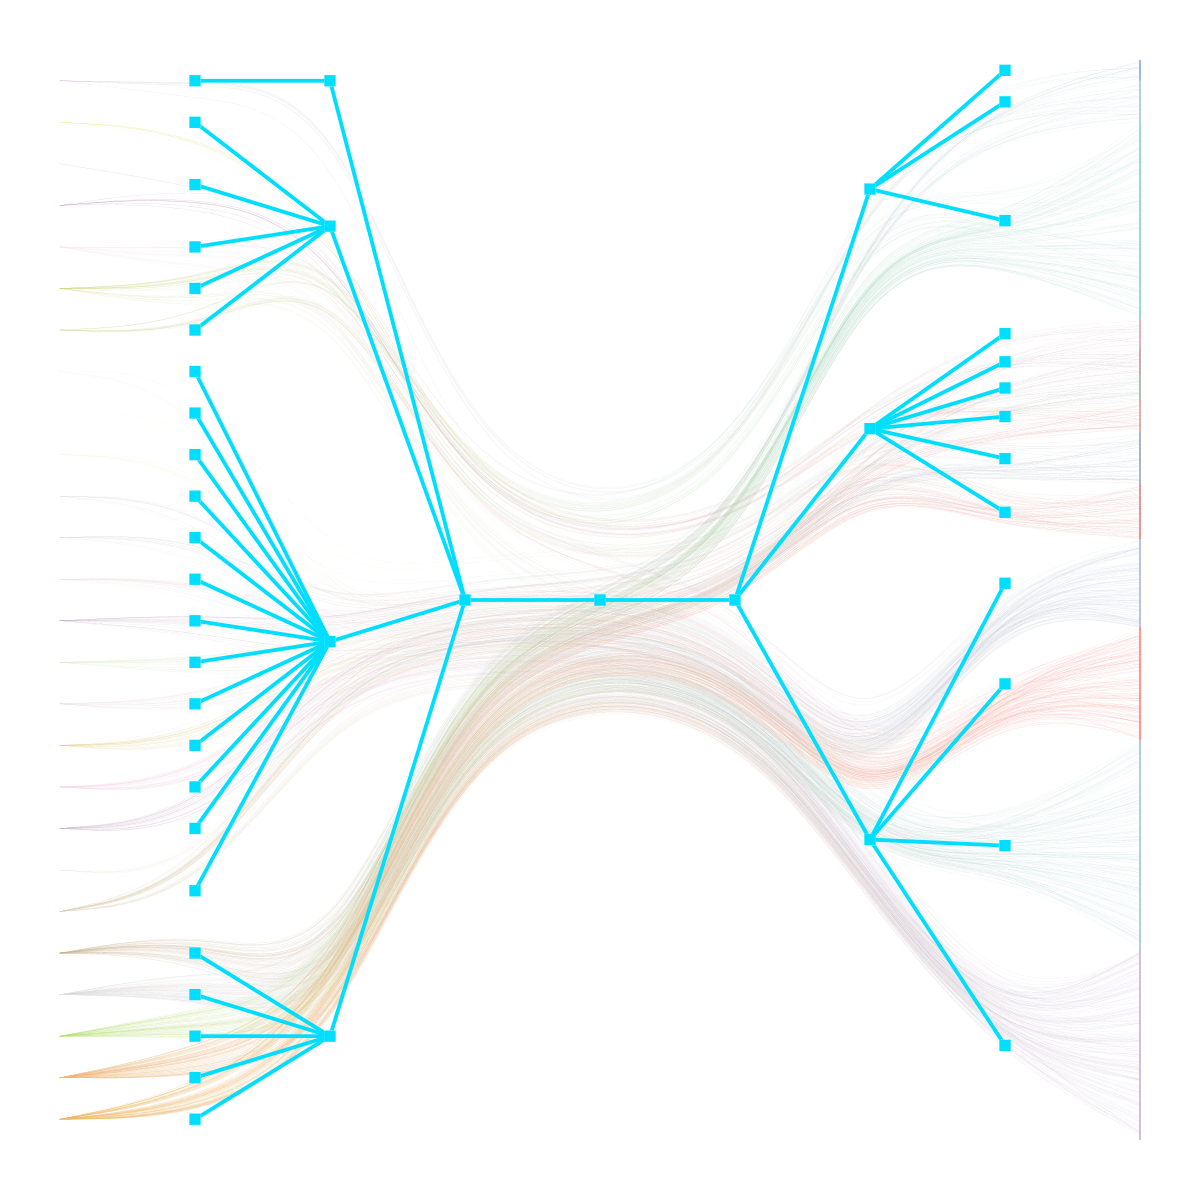

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7ff06932e470, at 0x7ff067bfd180>,
 <Graph object, directed, with 38490 vertices and 38489 edges, at 0x7ff0682dd750>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7ff0682dd750, at 0x7ff069329f00>)

In [33]:
model_100.state.draw(subsample_edges=1000,layout='bipartite',bip_aspect=1,
                 hvertex_size=8, hedge_pen_width=1.9, hedge_color="#00deff", hvertex_fill_color="#00DEFF", 
                 output_size=(600, 600))

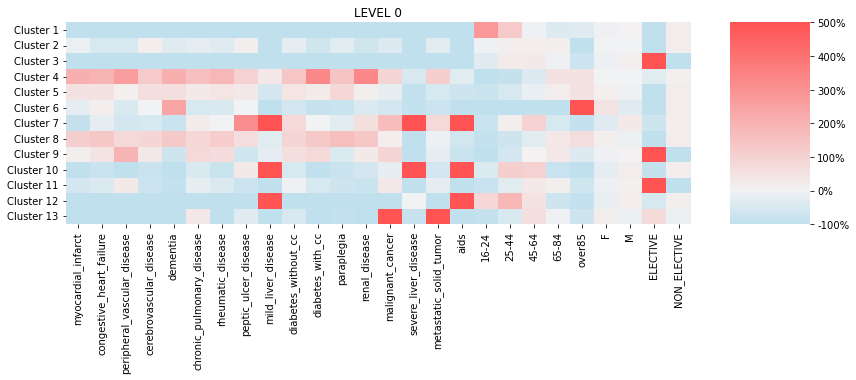

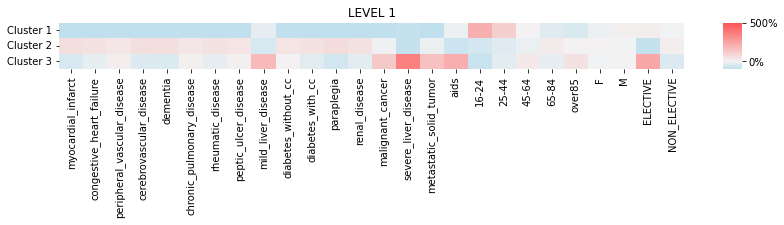

In [35]:
for l in [0,1]:
    clusters=model_100.clusters(l=l,n=50000)
    heatmap_df=pd.DataFrame()
    for k in clusters.keys():
        idx=[int(adm[0]) for adm in list(clusters[k])]
        block=input_df_no_outcomes[input_df_no_outcomes.index.isin(idx)]
        heatmap_df['Cluster {}'.format(k+1)]=block.mean()/input_df_no_outcomes.mean()-1
        #print(l,k,block.mean())
        #print('cluster {} len: {}'.format(k,len(clusters[k])))
    heatmap_df=heatmap_df.T*100
    fig, ax = plt.subplots(figsize=(14,float(len(clusters.keys())/3.5)))
    #sns.heatmap(heatmap_df, ax=ax, vmin=-1, center=0, vmax=3, cmap=sns.diverging_palette(238, 12, l=60, s=100, as_cmap=True))
    sns.heatmap(heatmap_df, ax=ax, cbar_kws={'format': '%.0f%%', 'aspect':2.5}, vmin=-100, center=0, vmax=500, cmap=sns.diverging_palette(238, 12, l=60, s=100, as_cmap=True))
    ax.set_title('LEVEL {}'.format(l))
    plt.show()

In [44]:
model_100.state = model_100.state.copy(bs=gt.order_nested_partition_labels(model_100.state.get_bs()))

In [45]:
cluster_df = pd.DataFrame(index=input_df_no_outcomes.index,columns=['Level_0_membership','Level_1_membership'])
bs = model_100.state.get_bs()
for v in model_100.g.vertices():
    try:
        pat_id_v=int(model.g.vp.name[v])        
        cluster_df.at[pat_id_v,'Level_0_membership'] = bs[0][int(v)]
        cluster_df.at[pat_id_v,'Level_1_membership'] = bs[1][cluster_df.at[pat_id_v,'Level_0_membership']]
    except:
        pass

In [46]:
cluster_df.groupby(by='Level_0_membership').Level_1_membership.mean().astype(int).to_dict()

{0: 4,
 1: 5,
 2: 4,
 3: 4,
 4: 4,
 5: 1,
 6: 1,
 7: 5,
 8: 1,
 9: 1,
 10: 1,
 11: 1,
 12: 5}

In [49]:
cluster_df.groupby(by='Level_0_membership').size()

Level_0_membership
0     7482
1     6939
2     6730
3     4024
4     3136
5     1911
6     1910
7     1510
8     1096
9     1083
10     948
11     914
12     734
dtype: int64

In [50]:
cluster_naming_dict={'Level_1_membership':{5:'A',1:'B',4:'C'},
                     'Level_0_membership':{12:'A1',7:'A2',1:'A3',11:'B1',10:'B2',9:'B3',8:'B4',6:'B5',5:'B6',4:'C1',3:'C2',2:'C3',0:'C4'}
                    }

In [51]:
cluster_df=cluster_df.replace(cluster_naming_dict)

In [54]:
cluster_df

Level_0_membership Level_1_membership
hadm_id                                      
163557                  A3                  A
129310                  C4                  C
129607                  A2                  A
177527                  A3                  A
127229                  C1                  C
...                    ...                ...
186679                  A3                  A
169431                  A3                  A
134959                  A3                  A
158288                  B2                  B
129161                  A2                  A

[38417 rows x 2 columns]

In [65]:
df = input_df
df=df.merge(cluster_df,  on='hadm_id',suffixes=('_x','')).drop(['Level_0_membership_x','Level_1_membership_x'],axis=1)

In [66]:
df.to_csv('./Results/dataframe_with_clusters_charlson.csv')

In [67]:
df

Unnamed: 0  ICUSTAY_ID  subject_id  hadm_id  admission_age  age_score  \
0           52841      200003       27513   163557             48          1   
1            7311      200007       20707   129310             44          1   
2           13534      200009       29904   129607             47          1   
3           33665      200012       28448   177527             33          0   
4           46297      200014        9514   127229             85          4   
...           ...         ...         ...      ...            ...        ...   
38412       60748      299992       13083   186679             41          1   
38413       48692      299993       13620   169431             26          0   
38414       49289      299995       28775   134959             24          0   
38415       37027      299998       69587   158288             87          4   
38416       10783      299999        7630   129161             49          1   

       myocardial_infarct  congestive_heart_failure  \
0                       0                         0   
1                       1                         0   
2                       0                         0   
3                       0                         0   
4                       1                         1   
...                   ...                       ...   
38412                   0                         0   
38413                   0                         0   
38414                   0                         0   
38415                   0                         0   
38416                   0                         0   

       peripheral_vascular_disease  cerebrovascular_disease  ...  M  ELECTIVE  \
0                                0                        0  ...  1         0   
1                                0                        0  ...  1         0   
2                                0                        0  ...  0         1   
3                                0                        0  ...  0         0   
4                                1                        0  ...  1         0   
...                            ...                      ...  ... ..       ...   
38412                            0                        0  ...  1         0   
38413                            0                        0  ...  1         0   
38414                            0                        0  ...  1         0   
38415                            0                        0  ...  1         1   
38416                            0                        0  ...  1         1   

       NON_ELECTIVE  sepsis  mortality  \
0                 1       1          0   
1                 1       0          0   
2                 0       0          0   
3                 1       0          0   
4                 1       1          0   
...             ...     ...        ...   
38412             1       0          0   
38413             1       0          0   
38414             1       0          0   
38415             0       1          0   
38416             0       0          0   

                                               diagnosis  icustay_id  sofa  \
0                                          S/P RESECTION      200003     6   
1                         RULE-OUT MYOCARDIAL INFARCTION      200007     1   
2      MITRAL REGURGITATION\MITRAL VALVE REPLACEMENT,...      200009     3   
3                                                  FEVER      200012     1   
4                              ABDOMINAL AORTIC ANEURYSM      200014     3   
...                                                  ...         ...   ...   
38412   STATUS POST MOTOR VEHICLE ACCIDENT WITH INJURIES      299992     4   
38413                             GALLSTONE PANCREATITIS      299993     0   
38414                                 STATUS EPILEPTICUS      299995     3   
38415                                 BLADDER CANCER/SDA      299998     4   
38416  MR\MITRAL VALVE REPLACEMENT MINIMALLY INVA

      Level_1_membership Level_0_membership  Morbidities
0                      A                 A3            0
1                      C                 C4            1
2                      A                 A2            0
3                      A                 A3            0
4                      C                 C1            4
...                  ...                ...          ...
38412                  A                 A3            0
38413                  A                 A3            0
38414                  A                 A3            0
38415                  B                 B2            3
38416                  A                 A2            0

[38417 rows x 3 columns]


/tmp/ipykernel_3506149/856573725.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_morbidity_count['Morbidities']=df[['myocardial_infarct', 'congestive_heart_failure',


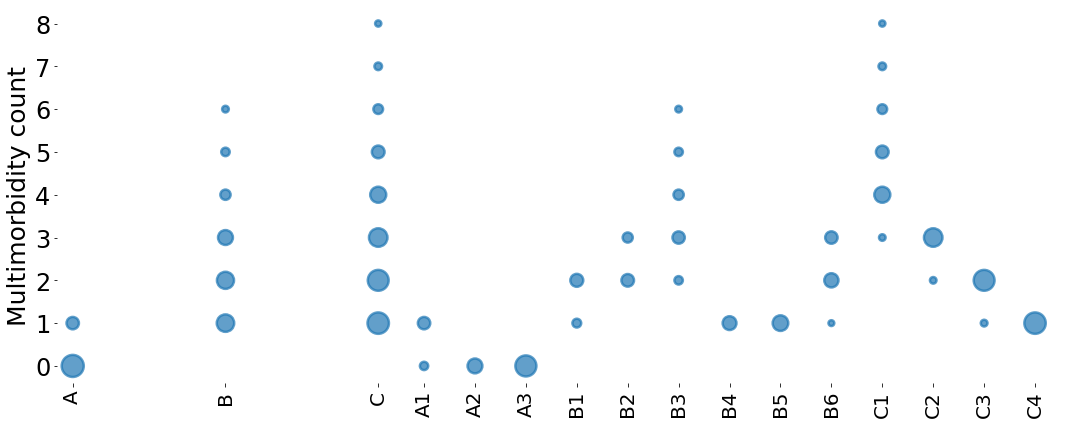

In [68]:
import matplotlib.colors as mc
import colorsys
import seaborn as sns

df_morbidity_count=df[['Level_1_membership','Level_0_membership']]
df_morbidity_count['Morbidities']=df[['myocardial_infarct', 'congestive_heart_failure',
       'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia',
       'chronic_pulmonary_disease', 'rheumatic_disease',
       'peptic_ulcer_disease', 'mild_liver_disease', 'diabetes_without_cc',
       'diabetes_with_cc', 'paraplegia', 'renal_disease', 'malignant_cancer',
       'severe_liver_disease', 'metastatic_solid_tumor']].sum(axis=1).astype(int)
print(df_morbidity_count)
def bubbleplot(df_morbidity_count,l):
    index = df_morbidity_count.groupby(['Level_{}_membership'.format(l),'Morbidities']).size().index
    x = index.map(lambda t: t[0])
    y = index.map(lambda t: t[1])
    areas = np.sqrt(df_morbidity_count.groupby(['Level_{}_membership'.format(l),'Morbidities']).size())+5
    return x,y,areas

# Set fonts

fig=plt.figure(figsize=(15,6))
gs = fig.add_gridspec(1, 2, hspace=0, wspace=0,width_ratios=[6,12])
(ax1, ax2)= gs.subplots(sharex='col', sharey='row')

#fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,6))                           
flierprops = dict(marker='o', markersize=3)
ax2.set_facecolor('white')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax1.set_facecolor('white')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

#palette_dict = {"#ff3939","#00deff","#00deff","#ffce29","#00ce00","#00ce00","#00ce00","#ff3939","#00deff","#00deff","#00deff","#00deff"}

for l in [1,0]:
    x,y,areas=bubbleplot(df_morbidity_count,l)
    if l==1:
        ax1.scatter(x, y, linewidths=2.5,s=areas * 5, alpha=0.7)
    if l==0:
        ax2.scatter(x, y, linewidths=2.5,s=areas * 5, alpha=0.7)
        
ax1.set_ylabel('Multimorbidity count', fontsize=25)
ax2.set_ylabel('')
ax2.set_xlabel('')
ax1.set_xlabel('')

ax2.tick_params(left=False)

plt.setp(ax1.get_xticklabels(), fontsize=20, rotation=90)
plt.setp(ax1.get_yticklabels(), fontsize=24)
plt.setp(ax2.get_xticklabels(), fontsize=20, rotation=90)

plt.tight_layout()
#plt.savefig('./Figures/multimorbidity_count.pdf', format='pdf', bbox_inches = "tight")
plt.show()

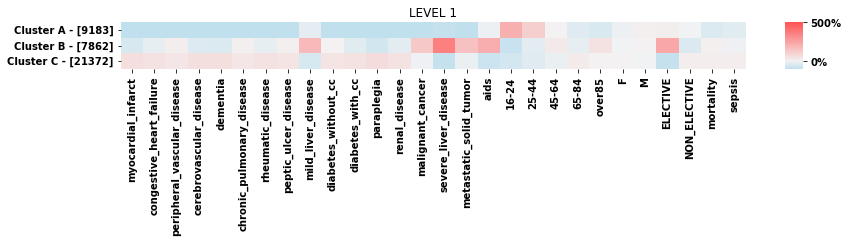

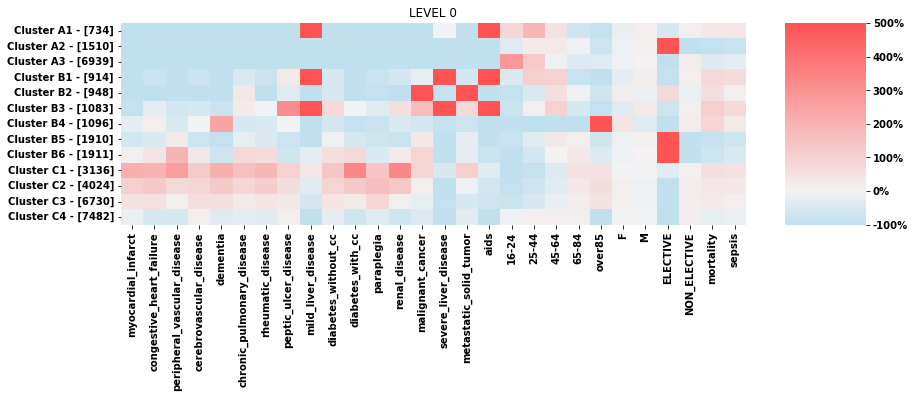

In [88]:
keep_col=['hadm_id','myocardial_infarct', 'congestive_heart_failure',
       'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia',
       'chronic_pulmonary_disease', 'rheumatic_disease',
       'peptic_ulcer_disease', 'mild_liver_disease', 'diabetes_without_cc',
       'diabetes_with_cc', 'paraplegia', 'renal_disease', 'malignant_cancer',
       'severe_liver_disease', 'metastatic_solid_tumor','aids','16-24', '25-44', '45-64',
       '65-84', 'over85', 'F', 'M', 'ELECTIVE', 'NON_ELECTIVE','mortality','sepsis']
df_outcomes=df[keep_col]

for l in [1,0]:
    heatmap_df=pd.DataFrame()
    for k in sorted(set(cluster_df['Level_{}_membership'.format(l)].values)):
        idx=cluster_df[cluster_df['Level_{}_membership'.format(l)]==k].index
        block=df_outcomes[df_outcomes.hadm_id.isin(idx)].drop('hadm_id', axis=1)
        heatmap_df['Cluster {} - [{}]'.format(k, len(idx))]=block.mean()/df_outcomes.drop('hadm_id', axis=1).mean()-1
        #print(l,k,block.mean())
        #print('cluster {} len: {}'.format(k,len(idx)))
    print('\n')
    heatmap_df=heatmap_df.T*100
    fig, ax = plt.subplots(figsize=(14,float(len(set(cluster_df['Level_{}_membership'.format(l)].values))/3.5)))
    sns.heatmap(heatmap_df, ax=ax, cbar_kws={'format': '%.0f%%', 'aspect':2.5}, vmin=-100, center=0, vmax=500, cmap=sns.diverging_palette(238, 12, l=60, s=100, as_cmap=True))
    ax.set_title('LEVEL {}'.format(l))
    plt.show()

In [83]:
df_outcomes

hadm_id  myocardial_infarct  congestive_heart_failure  \
0       163557                   0                         0   
1       129310                   1                         0   
2       129607                   0                         0   
3       177527                   0                         0   
4       127229                   1                         1   
...        ...                 ...                       ...   
38412   186679                   0                         0   
38413   169431                   0                         0   
38414   134959                   0                         0   
38415   158288                   0                         0   
38416   129161                   0                         0   

       peripheral_vascular_disease  cerebrovascular_disease  dementia  \
0                                0                        0         0   
1                                0                        0         0   
2                                0                        0         0   
3                                0                        0         0   
4                                1                        0         0   
...                            ...                      ...       ...   
38412                            0                        0         0   
38413                            0                        0         0   
38414                            0                        0         0   
38415                            0                        0         0   
38416                            0                        0         0   

       chronic_pulmonary_disease  rheumatic_disease  peptic_ulcer_disease  \
0                              0                  0                     0   
1                              0                  0                     0   
2                              0                  0                     0   
3                              0                  0                     0   
4                              1                  0                     0   
...                          ...                ...                   ...   
38412                          0                  0                     0   
38413                          0                  0                     0   
38414                          0                  0                     0   
38415                          0                  0                     0   
38416                          0                  0                     0   

       mild_liver_disease  ...  25-44  45-64  65-84  over85  F  M  ELECTIVE  \
0                       0  ...      0      1      0       0  0  1         0   
1                       0  ...      1      0      0       0  0  1         0   
2                       0  ...      0      1      0       0  1  0         1   
3                       0  ...      1      0      0       0  1  0         0   
4                       0  ...      0      0      0       1  0  1         0   
...                   ...  ...    ...    ...    ...     ... .. ..       ...   
38412                   0  ...      1      0      0       0  0  1         0   
38413                   0  ...      1      0      0       0  0  1         0   
38414                   0  ...      0      0      0       0  0  1         0   
38415                   0  ...      0      0      0       1  0  1         1   
38416                   0  ...      0      1      0       0  0  1         1   

       NON_ELECTIVE  mortality  sepsis  
0                 1          0       1  
1                 1          0       0  
2                 0          0       0  
3                 1          0       0  
4                 1          0       1  
...             ...        ...     ...  
38412             1          0       0  
38413             1          0       0  
38414             1          0       0  
38415             0          0       1  
38416             0          0      

In [76]:
df

Unnamed: 0  ICUSTAY_ID  subject_id  hadm_id  admission_age  age_score  \
0           52841      200003       27513   163557             48          1   
1            7311      200007       20707   129310             44          1   
2           13534      200009       29904   129607             47          1   
3           33665      200012       28448   177527             33          0   
4           46297      200014        9514   127229             85          4   
...           ...         ...         ...      ...            ...        ...   
38412       60748      299992       13083   186679             41          1   
38413       48692      299993       13620   169431             26          0   
38414       49289      299995       28775   134959             24          0   
38415       37027      299998       69587   158288             87          4   
38416       10783      299999        7630   129161             49          1   

       myocardial_infarct  congestive_heart_failure  \
0                       0                         0   
1                       1                         0   
2                       0                         0   
3                       0                         0   
4                       1                         1   
...                   ...                       ...   
38412                   0                         0   
38413                   0                         0   
38414                   0                         0   
38415                   0                         0   
38416                   0                         0   

       peripheral_vascular_disease  cerebrovascular_disease  ...  M  ELECTIVE  \
0                                0                        0  ...  1         0   
1                                0                        0  ...  1         0   
2                                0                        0  ...  0         1   
3                                0                        0  ...  0         0   
4                                1                        0  ...  1         0   
...                            ...                      ...  ... ..       ...   
38412                            0                        0  ...  1         0   
38413                            0                        0  ...  1         0   
38414                            0                        0  ...  1         0   
38415                            0                        0  ...  1         1   
38416                            0                        0  ...  1         1   

       NON_ELECTIVE  sepsis  mortality  \
0                 1       1          0   
1                 1       0          0   
2                 0       0          0   
3                 1       0          0   
4                 1       1          0   
...             ...     ...        ...   
38412             1       0          0   
38413             1       0          0   
38414             1       0          0   
38415             0       1          0   
38416             0       0          0   

                                               diagnosis  icustay_id  sofa  \
0                                          S/P RESECTION      200003     6   
1                         RULE-OUT MYOCARDIAL INFARCTION      200007     1   
2      MITRAL REGURGITATION\MITRAL VALVE REPLACEMENT,...      200009     3   
3                                                  FEVER      200012     1   
4                              ABDOMINAL AORTIC ANEURYSM      200014     3   
...                                                  ...         ...   ...   
38412   STATUS POST MOTOR VEHICLE ACCIDENT WITH INJURIES      299992     4   
38413                             GALLSTONE PANCREATITIS      299993     0   
38414                                 STATUS EPILEPTICUS      299995     3   
38415                                 BLADDER CANCER/SDA      299998     4   
38416  MR\MITRAL VALVE REPLACEMENT MINIMALLY INVA

In [12]:
ordered_state = model.state.copy()

In [13]:
ordered_state=gt.NestedBlockState(model.g, bs=gt.order_nested_partition_labels(ordered_state.get_bs()))

In [1037]:
model.state = ordered_state

In [1038]:
with open('./Results/final_model_AI4Health_mcmc_multiflip.pkl','wb') as f:
    pickle.dump(model,f)

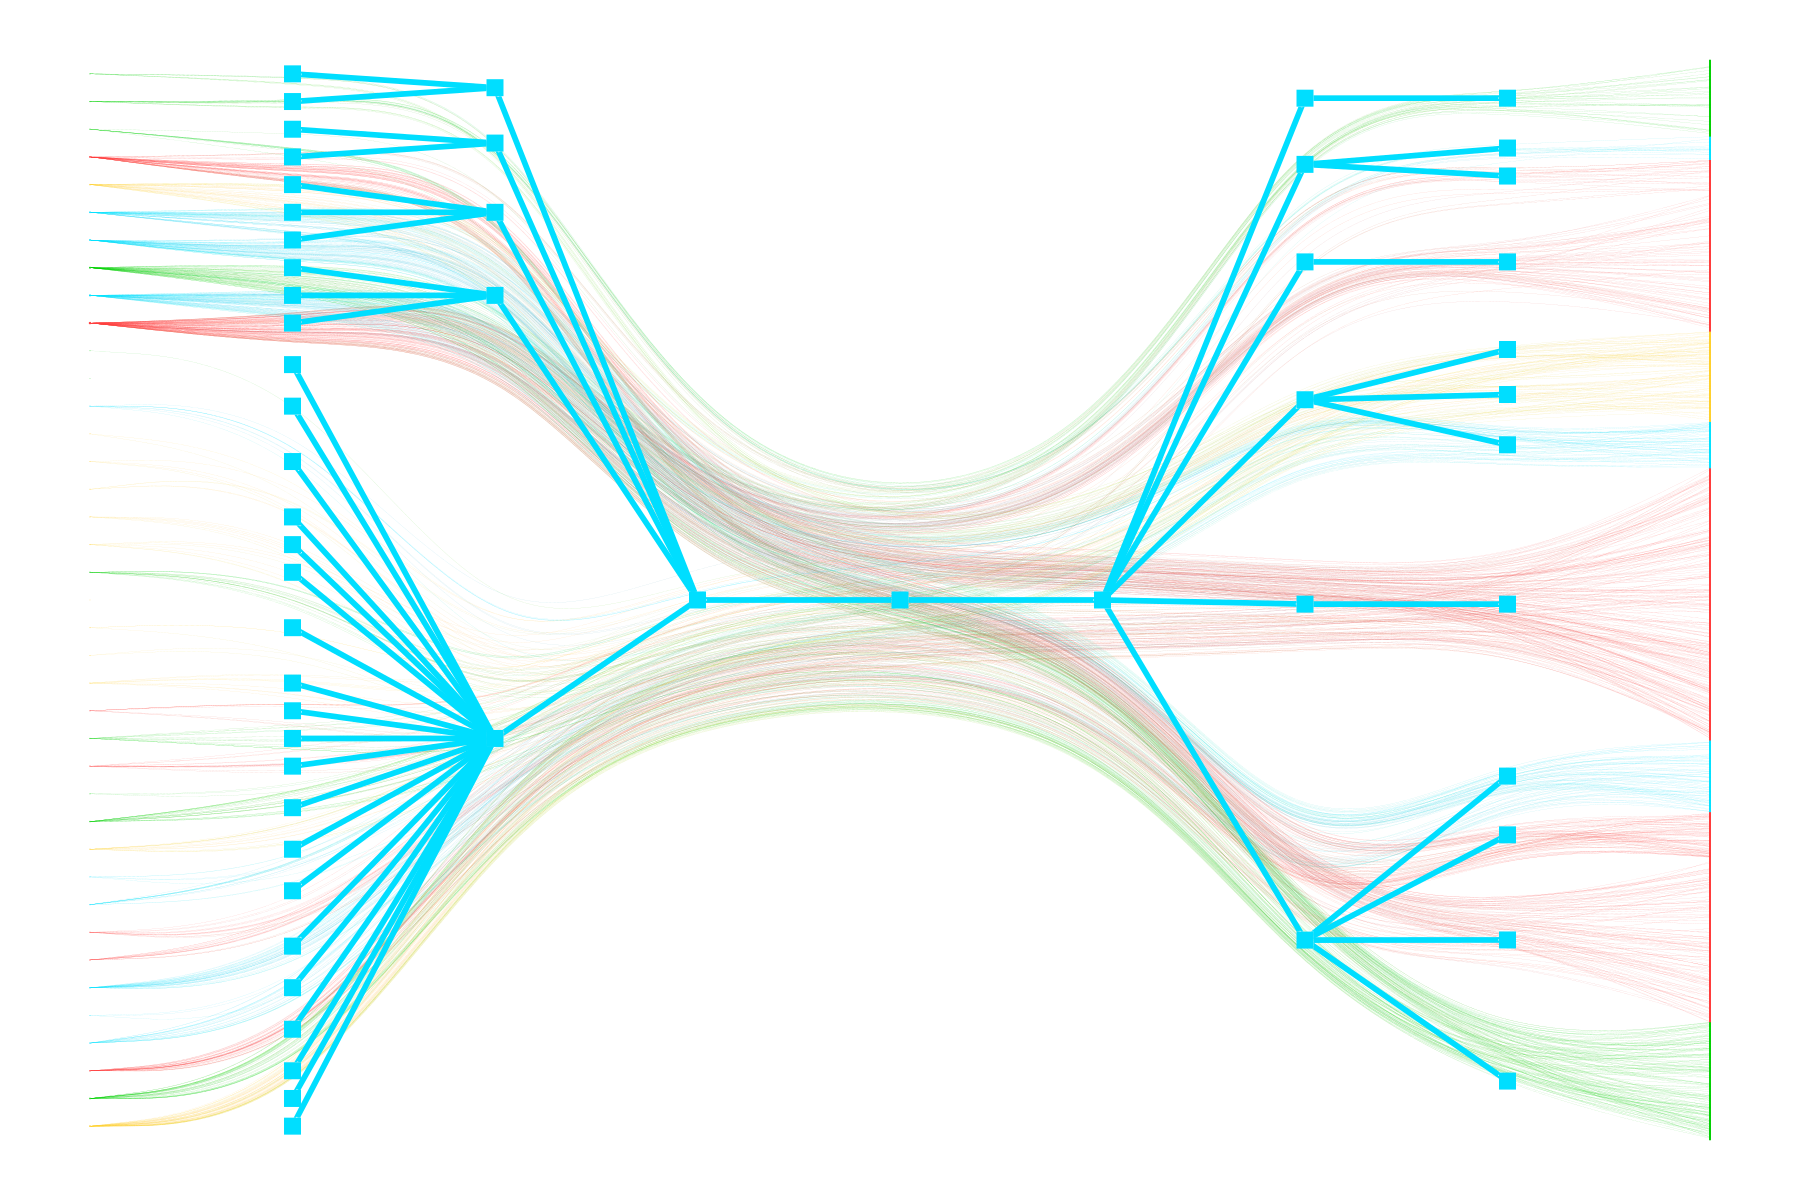

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x10454a970, at 0x167acacd0>,
 <Graph object, directed, with 38512 vertices and 38511 edges, at 0x13508f0d0>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x13508f0d0, at 0x166353be0>)

In [1039]:
#sanity check to see if we get the same clusters
r=1.5
model.state.draw(subsample_edges=1000,layout='bipartite',bip_aspect=1.5,
                 hvertex_size=8*r, hedge_pen_width=1.9*r, hedge_color="#00DEFF", hvertex_fill_color="#00DEFF", 
                 output_size=(600*r, 600*r),  output='./Figures/network_hierarchy.png', **kwargs)

In [15]:
ordered_state.get_bs()

[PropertyArray([ 0,  1,  0, ..., 18, 16, 15], dtype=int32),
 PropertyArray([ 8,  1,  9,  1, 10,  1,  2,  2,  1,  2,  5,  5,  0,  0,  0,
                 0,  0,  0,  0,  3,  4,  0,  0,  0,  4,  6,  4,  0,  0,  0,
                 3,  7,  7,  0,  0,  0,  0,  3,  0,  0,  6,  0],
               dtype=int32),
 PropertyArray([1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0], dtype=int32),
 PropertyArray([0, 0], dtype=int32)]

In [19]:
df_patient_ordered=pd.DataFrame(index=input_df.index, columns=['Level 0 membership','Level 1 membership'])

In [20]:
level_membership={0:{},1:{}}
level_membership[0]=ordered_state.get_levels()[0].get_blocks()
level_membership[1]=ordered_state.get_levels()[1].get_blocks()

In [21]:
for v in model.g.vertices():
    try:
        hadm_id_v=int(model.g.vp.name[v])
        level_0_membership = level_membership[0][v]
        level_1_membership = level_membership[1][level_0_membership]
        df_patient_ordered.loc[hadm_id_v]['Level 0 membership']=level_0_membership
        df_patient_ordered.loc[hadm_id_v]['Level 1 membership']=level_1_membership
    except:
        pass

In [23]:
print(set(df_patient_ordered['Level 0 membership'].values))
print(set(df_patient_ordered['Level 1 membership'].values))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}
{1, 2, 5, 8, 9, 10}


In [26]:
# Dictionary for the memberships at different level
cluster_hierarchy=df_patient_ordered.groupby(by='Level 0 membership').mean().astype(int).to_dict()

In [28]:
cluster_hierarchy

{'Level 1 membership': {1: 4,
  2: 1,
  3: 5,
  4: 1,
  5: 6,
  6: 1,
  7: 2,
  8: 2,
  9: 1,
  10: 2,
  11: 3,
  12: 3}}

In [35]:
inv_map = {}
for k, v in cluster_hierarchy['Level 1 membership'].items():
    inv_map[v] = inv_map.get(v, []) + [k]

In [36]:
inv_map

{4: [1], 1: [2, 4, 6, 9], 5: [3], 6: [5], 2: [7, 8, 10], 3: [11, 12]}

In [38]:
df_patient_ordered.groupby(by='Level 0 membership').count()

Level 1 membership
Level 0 membership                    
1                                 9679
2                                 5850
3                                 4945
4                                 4191
5                                 2716
6                                 2554
7                                 1918
8                                 1658
9                                 1627
10                                1286
11                                1162
12                                 831

In [39]:
# Rename clusters to match the order on the network figure
level_1_rename={6:1, 3:2, 5:3, 2:4, 4:5, 1:6}
level_0_rename={5:1, 12:2, 11:3, 3:4, 10:5, 7:6, 8:7, 1:8, 6:9, 9:10, 2:11, 4:12}

In [40]:
df_patient_ordered.replace({'Level 0 membership':level_0_rename, 'Level 1 membership':level_1_rename},inplace=True)

In [45]:
df_patient_ordered.groupby(by='Level 0 membership').mean().astype(int).to_dict()

{'Level 1 membership': {1: 1,
  2: 2,
  3: 2,
  4: 3,
  5: 4,
  6: 4,
  7: 4,
  8: 5,
  9: 6,
  10: 6,
  11: 6,
  12: 6}}

In [47]:
df_patient_ordered.groupby(by='Level 0 membership').mean()

Level 1 membership
Level 0 membership                    
1                                  1.0
2                                  2.0
3                                  2.0
4                                  3.0
5                                  4.0
6                                  4.0
7                                  4.0
8                                  5.0
9                                  6.0
10                                 6.0
11                                 6.0
12                                 6.0

In [49]:
input_df_no_outcomes_membership = pd.concat([input_df_no_outcomes, df_patient_ordered], axis=1)

In [50]:
input_df_no_outcomes_membership

congestive_heart_failure  cardiac_arrhythmias  valvular_disease  \
hadm_id                                                                    
100001                        0.0                  0.0               0.0   
100003                        0.0                  0.0               0.0   
100006                        0.0                  1.0               0.0   
100007                        0.0                  0.0               0.0   
100009                        0.0                  1.0               0.0   
...                           ...                  ...               ...   
199992                        0.0                  0.0               0.0   
199993                        1.0                  1.0               1.0   
199995                        0.0                  0.0               1.0   
199998                        0.0                  1.0               0.0   
199999                        0.0                  0.0               0.0   

         pulmonary_circulation  peripheral_vascular  hypertension  paralysis  \
hadm_id                                                                        
100001                     0.0                  0.0             1        0.0   
100003                     0.0                  0.0             1        0.0   
100006                     0.0                  0.0             0        0.0   
100007                     0.0                  0.0             1        0.0   
100009                     0.0                  1.0             1        0.0   
...                        ...                  ...           ...        ...   
199992                     0.0                  1.0             0        0.0   
199993                     0.0                  0.0             0        0.0   
199995                     0.0                  1.0             0        0.0   
199998                     0.0                  1.0             1        0.0   
199999                     0.0                  0.0             0        0.0   

         other_neurological  chronic_pulmonary  diabetes_uncomplicated  ...  \
hadm_id                                                                 ...   
100001                  0.0                0.0                       0  ...   
100003                  0.0                0.0                       0  ...   
100006                  0.0                0.0                       0  ...   
100007                  0.0                0.0                       0  ...   
100009                  0.0                0.0                       1  ...   
...                     ...                ...                     ...  ...   
199992                  0.0                0.0                       0  ...   
199993                  0.0                0.0                       0  ...   
199995                  0.0                0.0                       0  ...   
199998                  0.0                0.0                       0  ...   
199999                  0.0                0.0                       0  ...   

         25-44  45-64  65-84  over85  F  M  ELECTIVE  NON_ELECTIVE  \
hadm_id                                                              
100001       1      0      0       0  1  0         0             1   
100003       0      1      0       0  0  1         0             1   
100006       0      1      0       0  1  0         0             1   
100007       0      0      1       0  1  0         0             1   
100009       0      1      0       0  0  1         0             1   
...        ...    ...    ...     ... .. ..       ...           ...   
199992       0      0      0       1  1  0         0             1   
199993       0      1      0       0  0  1         0             1   
199995       0      0      0       0  0  1         0             1   
199998       0      0      1       0  0  1         0             1   
199999       0      0      0       1  0  1         0             1   

         Level 0 membership  Level 1 mem

In [51]:
df_patient_ordered

Level 0 membership  Level 1 membership
hadm_id                                        
100001                    8                   5
100003                   11                   6
100006                    8                   5
100007                    4                   3
100009                    7                   4
...                     ...                 ...
199992                    9                   6
199993                    8                   5
199995                    6                   4
199998                    8                   5
199999                    4                   3

[38417 rows x 2 columns]

In [52]:
input_df_no_outcomes

congestive_heart_failure  cardiac_arrhythmias  valvular_disease  \
hadm_id                                                                    
100001                        0.0                  0.0               0.0   
100003                        0.0                  0.0               0.0   
100006                        0.0                  1.0               0.0   
100007                        0.0                  0.0               0.0   
100009                        0.0                  1.0               0.0   
...                           ...                  ...               ...   
199992                        0.0                  0.0               0.0   
199993                        1.0                  1.0               1.0   
199995                        0.0                  0.0               1.0   
199998                        0.0                  1.0               0.0   
199999                        0.0                  0.0               0.0   

         pulmonary_circulation  peripheral_vascular  hypertension  paralysis  \
hadm_id                                                                        
100001                     0.0                  0.0             1        0.0   
100003                     0.0                  0.0             1        0.0   
100006                     0.0                  0.0             0        0.0   
100007                     0.0                  0.0             1        0.0   
100009                     0.0                  1.0             1        0.0   
...                        ...                  ...           ...        ...   
199992                     0.0                  1.0             0        0.0   
199993                     0.0                  0.0             0        0.0   
199995                     0.0                  1.0             0        0.0   
199998                     0.0                  1.0             1        0.0   
199999                     0.0                  0.0             0        0.0   

         other_neurological  chronic_pulmonary  diabetes_uncomplicated  ...  \
hadm_id                                                                 ...   
100001                  0.0                0.0                       0  ...   
100003                  0.0                0.0                       0  ...   
100006                  0.0                0.0                       0  ...   
100007                  0.0                0.0                       0  ...   
100009                  0.0                0.0                       1  ...   
...                     ...                ...                     ...  ...   
199992                  0.0                0.0                       0  ...   
199993                  0.0                0.0                       0  ...   
199995                  0.0                0.0                       0  ...   
199998                  0.0                0.0                       0  ...   
199999                  0.0                0.0                       0  ...   

         depression  16-24  25-44  45-64  65-84  over85  F  M  ELECTIVE  \
hadm_id                                                                   
100001          0.0      0      1      0      0       0  1  0         0   
100003          0.0      0      0      1      0       0  0  1         0   
100006          1.0      0      0      1      0       0  1  0         0   
100007          0.0      0      0      0      1       0  1  0         0   
100009          0.0      0      0      1      0       0  0  1         0   
...             ...    ...    ...    ...    ...     ... .. ..       ...   
199992          0.0      0      0      0      0       1  1  0         0   
199993          0.0      0      0      1      0       0  0  1         0   
199995          0.0      1      0      0      0       0  0  1         0   
199998          0.0      0      0      0      1       0  0  1         0   
199999          0.0      0      0      0      0    

In [801]:
cluster_to_pat_dict = {0:{},1:{}}
for l in [0,1]:
    pat_to_cluster_dict = df_complete['Level {} membership'.format(l)].to_dict()
    for k, v in pat_to_cluster_dict.items():
        cluster_to_pat_dict[l][v] = cluster_to_pat_dict[l].get(v, []) + [k]

In [67]:
# Sanity check: check if the numbers of patients in the clusters are the same

for l in [0,1]:
    for k in cluster_to_pat_dict[l].keys():
        print(k, len(cluster_to_pat_dict[l][k]))
    print('\n')
df_patient_ordered.groupby(by='Level 1 membership').count()

8 9679
11 5850
4 4945
7 1658
2 831
6 1918
5 1286
1 2716
12 4191
3 1162
10 1627
9 2554


5 9679
6 14222
3 4945
4 4862
2 1993
1 2716




Level 0 membership
Level 1 membership                    
1                                 2716
2                                 1993
3                                 4945
4                                 4862
5                                 9679
6                                14222

In [802]:
from collections import OrderedDict
ordered_cluster_to_pat=cluster_to_pat_dict
for l in [0,1]:
    ordered_cluster_to_pat[l]=OrderedDict(sorted(ordered_cluster_to_pat[l].items(), key=lambda t: t[0]))

In [803]:
heatmap_df = {}
for l in [0,1]:
    heatmap_df[l]=pd.DataFrame()
    clusters = ordered_cluster_to_pat[l]
    for k in clusters.keys():
        idx=[int(adm) for adm in list(clusters[k])]
        block=input_df_no_outcomes[input_df_no_outcomes.index.isin(idx)]
        if l==0:
            heatmap_df[l][k]=block.mean()/input_df_no_outcomes.mean()-1
        else:
            heatmap_df[l][k]=block.mean()/input_df_no_outcomes.mean()-1

    heatmap_df[l]=heatmap_df[l].T*100

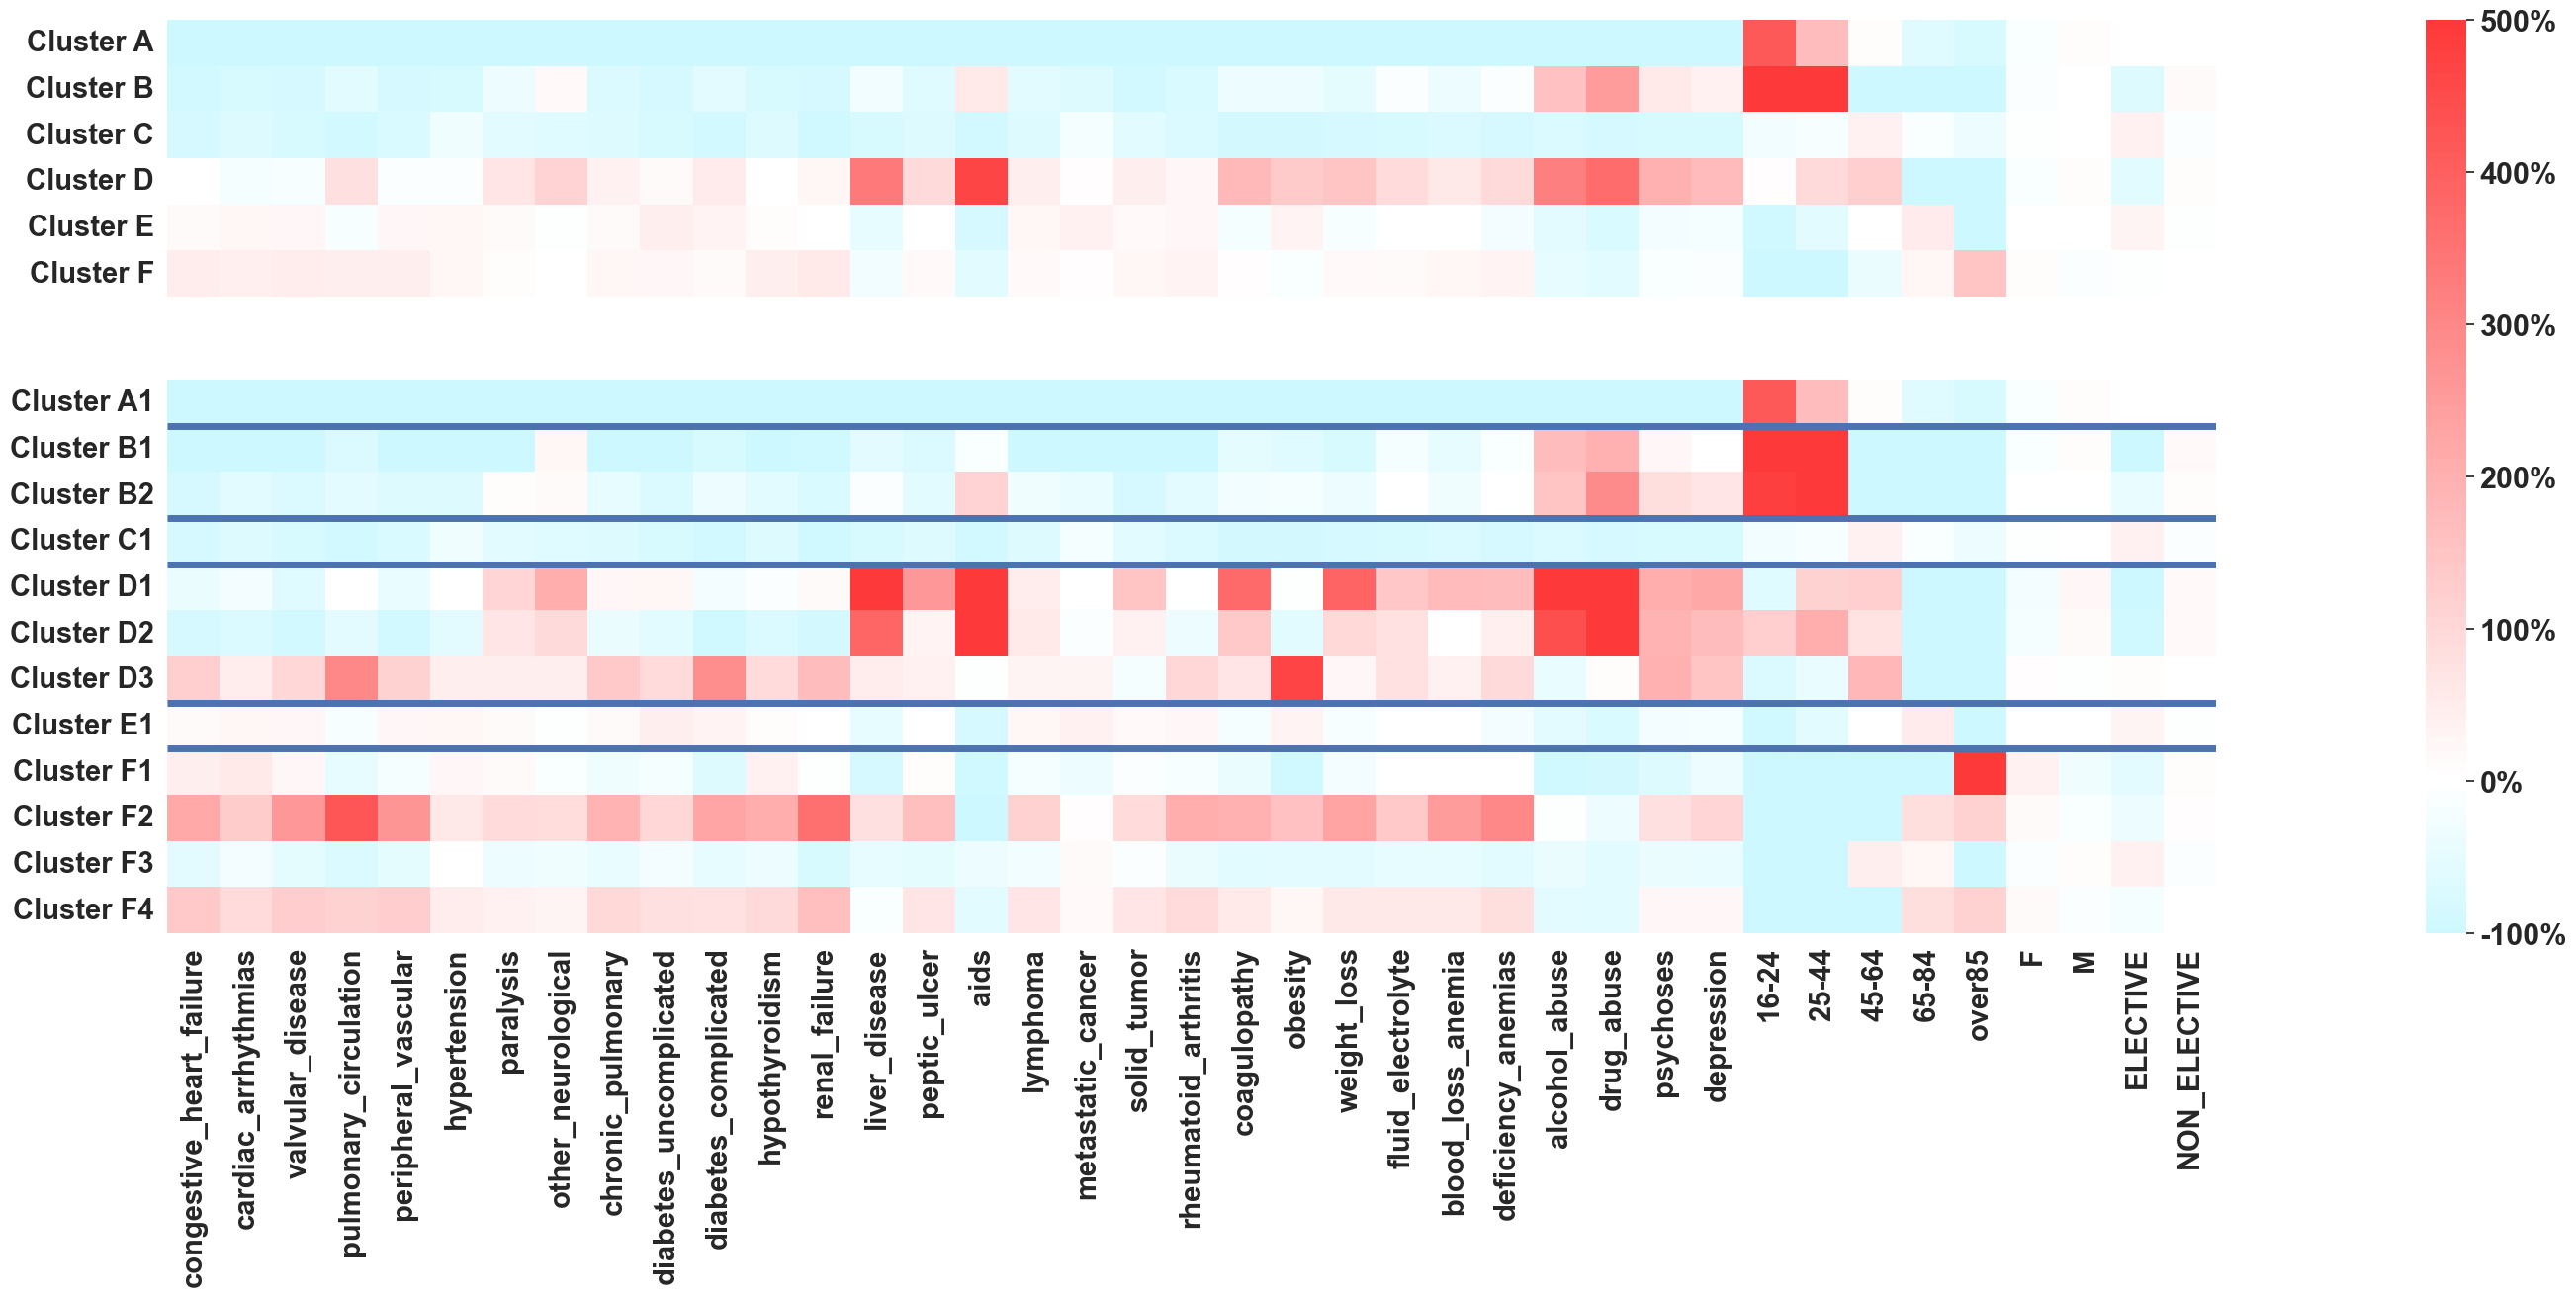

In [1035]:
import matplotlib.gridspec as gs
plt.rcParams["font.weight"] = "bold"

site = heatmap_df[1]
country = heatmap_df[0]

sns.set(font_scale = 2)

fig = plt.figure(figsize=(30,12))
N_rows_site, _ = site.shape
N_rows_country, _ = country.shape

grid=gs.GridSpec(2,2, height_ratios=[N_rows_site,N_rows_country], width_ratios=[50,1], )

ax1 = fig.add_subplot(grid[0,0])
ax2 = fig.add_subplot(grid[1,0], sharex=ax1)
cax = fig.add_subplot(grid[:,1])

sns.heatmap(site, ax=ax1, cbar_ax=cax, cbar_kws={'format': '%.0f%%', 'aspect':2.5}, vmin=-100, center=0, vmax=500, cmap=double)
sns.heatmap(country, ax=ax2, cbar_ax=cax, cbar_kws={'format': '%.0f%%', 'aspect':2.5}, vmin=-100, center=0, vmax=500, cmap=double)

ax1.tick_params(labelsize=21)
ax2.tick_params(labelsize=21)

ax1.tick_params(left=False, bottom=False)
ax2.tick_params(left=False, bottom=False)
ax2.hlines([1, 3, 4, 7, 8], *ax2.get_xlim(), **{'linewidth':5})

plt.setp(ax1.get_xticklabels(), visible=False)
plt.savefig('./Figures/heatmaps.pdf',format='pdf', bbox_inches = "tight")
plt.show()

In [ ]:
### Bar plot for sepsis and mortality
def bar_plot(df):
    plt.rcParams["figure.figsize"] = (30,10)
    plt.rcParams.update({'font.size': 25})
    sepsis_color = "#fdae6b"
    mortality_color = "#3182bd"
    # creating data
    cluster_lvl_1 = len(sepsis_lvl_1)
    cluster_lvl_1 = len(sepsis_lvl_0)
    sepsis_all    = sepsis_lvl_1 + sepsis_lvl_0
    mortality_all = mortality_lvl_1 + mortality_lvl_0

    xsepsis_all = [(k-0.1) for k in range(len(sepsis_all))]
    xdata_all   = [(k) for k in range(len(mortality_all))]
    labels = [str(k) for k in range(len(sepsis_lvl_1))] + [str(k) for k in range(len(sepsis_lvl_0))] # I am keeping manually 4, need to change to len(model.clusters(l=1, n=5000))

    # plotting data
    plt.bar(xdata_all, mortality_all, ls='-', width=0.075, color=mortality_color)
    plt.plot(xdata_all, mortality_all, marker="o", linestyle="", alpha=0.8, color=mortality_color)
    
    plt.bar(xsepsis_all, sepsis_all, ls='-', width=0.075, color=sepsis_color, label='Sepsis')
    plt.plot(xsepsis_all, sepsis_all, marker="o", linestyle="", alpha=0.8, color=sepsis_color)
    
    plt.plot([0]*(1+len(xdata_all)), linewidth = 0.3, linestyle = '-', color="#2c7fb8")
    plt.rc('axes', labelsize=15)
    plt.xlabel("", fontsize=25)
    plt.ylabel("Difference from the average (%)", fontsize=25)
    plt.xticks(xdata_all,labels)
    plt.axvline(x=len(sepsis_lvl_1)-0.5, color='0.8', label='axvline - full height')
    
    # Displaying plot
    plt.show()

In [176]:
outcomes_df = input_df[['sepsis','mortality','mortality_given_sepsis']]
barplot_df = {}
for l in [0,1]:
    barplot_df[l]=pd.DataFrame()
    clusters = ordered_cluster_to_pat[l]
    for k in clusters.keys():
        idx=[int(adm) for adm in list(clusters[k])]
        block=outcomes_df[outcomes_df.index.isin(idx)]
        if l==0:
            barplot_df[l]['Cluster {}'.format(k)]=block.mean()/outcomes_df.mean()-1
        else:
            barplot_df[l]['Cluster {}'.format(cluster_to_letters[k])]=block.mean()/outcomes_df.mean()-1
    barplot_df[l]=barplot_df[l].T*100

In [303]:
input_df_outcomes_membership = pd.concat([input_df, df_patient_ordered], axis=1)
input_df_outcomes_membership.groupby(['Level 0 membership','sepsis'])['mortality'].mean()

Level 0 membership  sepsis
1                   0         0.052996
                    1         0.133080
2                   0         0.034024
                    1         0.058065
3                   0         0.034934
                    1         0.109756
4                   0         0.067925
                    1         0.170213
5                   0         0.089701
                    1         0.238304
6                   0         0.072568
                    1         0.231928
7                   0         0.053007
                    1         0.184638
8                   0         0.067252
                    1         0.202982
9                   0         0.173987
                    1         0.298377
10                  0         0.123249
                    1         0.262870
11                  0         0.061864
                    1         0.194690
12                  0         0.108458
                    1         0.247093
Name: mortality, dtype: float64

In [315]:
sepsis_df = input_df_outcomes_membership[input_df_outcomes_membership.sepsis==1]

0.24709302325581395

In [180]:
barplot_df[0]

sepsis  mortality
Cluster 1   -64.818842 -46.788071
Cluster 2   -32.233537 -66.270976
Cluster 3   -23.084632 -55.526562
Cluster 4   -48.202719 -27.731559
Cluster 5    93.240999  47.799711
Cluster 6    25.777691  11.885112
Cluster 7    48.350251  -6.493121
Cluster 8    -1.804544  -8.962083
Cluster 9    13.945129  86.566140
Cluster 10  103.876592  76.579837
Cluster 11  -29.821074 -23.339982
Cluster 12   49.105934  44.833956

In [187]:
barplot_df[1]

sepsis  mortality
Cluster A -64.818842 -46.788071
Cluster B -26.899354 -60.006546
Cluster C -48.202719 -27.731559
Cluster D  51.319262  15.117334
Cluster E  -1.804544  -8.962083
Cluster F  16.592094  27.917700

Level 1 membership
1    0.133080
2    0.089776
3    0.170213
4    0.218272
5    0.202982
6    0.246275
Name: mortality, dtype: float64

In [380]:
avg_mort_seps=sepsis_df['mortality'].mean()
new_col = {0:pd.DataFrame(index=barplot_df[0].index, columns=['mortality_given_sepsis']),
           1:pd.DataFrame(index=barplot_df[1].index, columns=['mortality_given_sepsis'])}
for l in [0,1]:
    for i, cluster in enumerate(barplot_df[l].index):
        new_col[l].loc[cluster] = 100*(sepsis_df.groupby(['Level {} membership'.format(l)])['mortality'].mean().loc[i+1]/avg_mort_seps-1)
new_col

{0:            mortality_given_sepsis
 Cluster 1              -38.497102
 Cluster 2              -73.165464
 Cluster 3              -49.276181
 Cluster 4              -21.336111
 Cluster 5                10.13232
 Cluster 6                7.185473
 Cluster 7              -14.669433
 Cluster 8               -6.191959
 Cluster 9               37.895048
 Cluster 10              21.485305
 Cluster 11             -10.023826
 Cluster 12              14.194127,
 1:           mortality_given_sepsis
 Cluster A             -38.497102
 Cluster B             -58.510193
 Cluster C             -21.336111
 Cluster D               0.874299
 Cluster E              -6.191959
 Cluster F              13.816168}

In [382]:
for l in [0,1]:
    barplot_df[l]=pd.concat([barplot_df[l], new_col[l]], axis=1)

In [381]:
for l in [0,1]:
    barplot_df[l]=barplot_df[l][['sepsis','mortality']]

In [383]:
barplot_df[0]

sepsis  mortality mortality_given_sepsis
Cluster 1   -64.818842 -46.788071             -38.497102
Cluster 2   -32.233537 -66.270976             -73.165464
Cluster 3   -23.084632 -55.526562             -49.276181
Cluster 4   -48.202719 -27.731559             -21.336111
Cluster 5    93.240999  47.799711               10.13232
Cluster 6    25.777691  11.885112               7.185473
Cluster 7    48.350251  -6.493121             -14.669433
Cluster 8    -1.804544  -8.962083              -6.191959
Cluster 9    13.945129  86.566140              37.895048
Cluster 10  103.876592  76.579837              21.485305
Cluster 11  -29.821074 -23.339982             -10.023826
Cluster 12   49.105934  44.833956              14.194127

In [917]:
adm_gend_df = {0:pd.DataFrame(index=df_complete.groupby(['Level 0 membership']).count().index),
               1:pd.DataFrame(index=df_complete.groupby(['Level 1 membership']).count().index)}

for l in [0,1]:
    adm_gend_df[l]['Electives'] = 100*(df_complete.groupby(['Level {} membership'.format(l)])['ELECTIVE'].mean().values/df_complete.ELECTIVE.mean()-1)
    adm_gend_df[l]['Females'] = 100*(df_complete.groupby(['Level {} membership'.format(l)])['F'].mean().values/df_complete.F.mean()-1)

In [1003]:
adm_gend_df = {0:pd.DataFrame(index=df_complete.groupby(['Level 0 membership']).count().index),
               1:pd.DataFrame(index=df_complete.groupby(['Level 1 membership']).count().index)}

for l in [0,1]:
    adm_gend_df[l]['Electives'] = 100*(df_complete.groupby(['Level {} membership'.format(l)])['ELECTIVE'].mean().values)
    adm_gend_df[l]['Females'] = 100*(df_complete.groupby(['Level {} membership'.format(l)])['F'].mean().values)

In [916]:
df_complete.groupby(['Level {} membership'.format(l)])['ELECTIVE'].mean().values

array([0.15684831, 0.05117913, 0.21961577, 0.06293706, 0.20374006,
       0.15061173])

In [918]:
adm_gend_df

{0:                      Electives    Females
 Level 0 membership                       
 Cluster A1           -0.138525 -12.184822
 Cluster B1         -100.000000 -14.784978
 Cluster B2          -44.112821  -0.350207
 Cluster C1           39.823984  -6.055366
 Cluster D1          -98.019672 -25.563501
 Cluster D2          -93.692996 -20.747016
 Cluster D3            8.672598   7.680049
 Cluster E1           29.716303   1.068680
 Cluster F1          -54.630015  39.897301
 Cluster F2          -36.606373  16.253252
 Cluster F3           38.327276 -10.218682
 Cluster F4          -19.940828  13.543003,
 1:                     Electives    Females
 Level 1 membership                      
 Cluster A           -0.138525 -12.184822
 Cluster B          -67.415503  -6.368920
 Cluster C           39.823984  -6.055366
 Cluster D          -59.929514 -12.327009
 Cluster E           29.716303   1.068680
 Cluster F           -4.109202   8.811783}

In [782]:
prevalence_df = {0:pd.DataFrame(index=barplot_df[0].index),
                 1:pd.DataFrame(index=barplot_df[1].index)}

for l in [0,1]:
    prevalence_df[l]['Sepsis'] = 100*input_df_outcomes_membership.groupby(['Level {} membership'.format(l)])['sepsis'].mean().values
    prevalence_df[l]['Mortality'] = 100*sepsis_df.groupby(['Level {} membership'.format(l)])['mortality'].mean().values
    prevalence_df[l]['MortalityP'] = 100*input_df_outcomes_membership.groupby(['Level {} membership'.format(l)])['mortality'].mean().values

In [783]:
prevalence_df

{0:                Sepsis  Mortality  MortalityP
 Cluster 1    9.683358  13.307985    6.075110
 Cluster 2   18.652226   5.806452    3.850782
 Cluster 3   21.170396  10.975610    5.077453
 Cluster 4   14.256825  17.021277    8.250758
 Cluster 5   53.188180  23.830409   16.874028
 Cluster 6   34.619395  23.192771   12.773723
 Cluster 7   40.832328  18.463811   10.675513
 Cluster 8   27.027585  20.298165   10.393636
 Cluster 9   31.362569  29.837703   21.299922
 Cluster 10  56.115550  26.286966   20.159803
 Cluster 11  19.316239  19.469027    8.752137
 Cluster 12  41.040325  24.709302   16.535433,
 1:               Sepsis  Mortality  MortalityP
 Cluster A   9.683358  13.307985    6.075110
 Cluster B  20.120421   8.977556    4.565981
 Cluster C  14.256825  17.021277    8.250758
 Cluster D  41.649527  21.827160   13.142740
 Cluster E  27.027585  20.298165   10.393636
 Cluster F  32.091126  24.627520   14.604134}

/var/folders/fq/wt1x9tfs2nd53vf0mvvhmnjc0000gn/T/ipykernel_14139/645376048.py:82: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(labels_1)+list(labels_0),rotation=90)
/var/folders/fq/wt1x9tfs2nd53vf0mvvhmnjc0000gn/T/ipykernel_14139/645376048.py:83: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.setp(ax.get_xticklabels(), Fontsize=12)
/var/folders/fq/wt1x9tfs2nd53vf0mvvhmnjc0000gn/T/ipykernel_14139/645376048.py:84: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.setp(ax.get_yticklabels(), Fontsize=15)


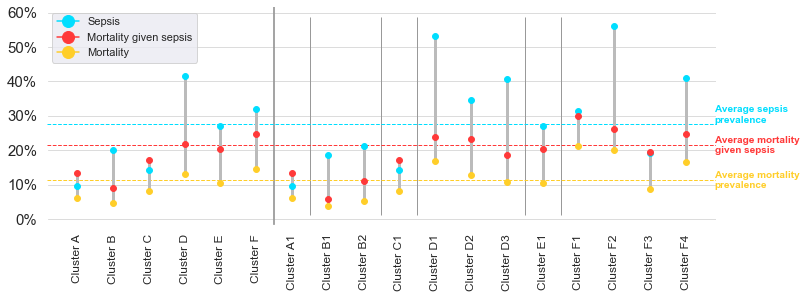

In [815]:
# create data
values_sep=np.append(prevalence_df[1].Sepsis.values,prevalence_df[0].Sepsis.values)
values_mor=np.append(prevalence_df[1].Mortality.values,prevalence_df[0].Mortality.values)
values_morp=np.append(prevalence_df[1].MortalityP.values,prevalence_df[0].MortalityP.values)
indexes=np.append(prevalence_df[1].index,prevalence_df[0].index)

# Set fonts
font_path='/Users/valerio/Library/Fonts/Lato-Black.ttf'
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()
plt.rcParams["font.weight"] = "normal"

# Set colours
sepsis_colour='#00DEFF'
mortality_colour='#ff3939'
mortalityp_colour="#ffce29"

fig, ax = plt.subplots(figsize=(12,4))
sns.set(font_scale = 1)

ax.yaxis.grid(True, color='#BBBBBB', ls='-', lw=0.5, zorder=1)

import matplotlib.ticker as mtick
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

ax.set_facecolor('white')
plt.axvline(x = 5.5, color = "#999999", linewidth='1.75' ,linestyle = '-', zorder=2)

plt.axhline(y = sepsis_df.mortality.mean()*100, color = mortality_colour, linewidth='1' ,linestyle = '--', zorder=3)
plt.annotate('Average mortality \ngiven sepsis',
              xy = (ax.get_xlim()[-1],sepsis_df.mortality.mean()*100-2.5), 
              xytext =(17.8,sepsis_df.mortality.mean()*100-2.5),
              color=mortality_colour,
              fontweight='bold',
              fontsize = 10)

plt.axhline(y = df_complete.sepsis.mean()*100, color = sepsis_colour, linewidth='1' ,linestyle = '--', zorder=3)
plt.annotate('Average sepsis \nprevalence',
              xy = (ax.get_xlim()[-1],df_complete.sepsis.mean()*100+0.5), 
              xytext =(17.8,df_complete.sepsis.mean()*100+0.5),
              color=sepsis_colour,
              fontweight='bold',
              fontsize = 10)

F

#plt.vlines(x = [6.5, 8.5, 9.5, 12.5, 13.5], color = '#ff3939', linewidth='0.75' ,linestyle = '-', zorder=2)
#ax2.hlines([1, 3, 4, 7, 8], *ax.get_xlim(), **{'linewidth':5})

plt.vlines(x=indexes, ymin=values_morp, ymax=np.maximum(values_sep,values_mor), color='#BBBBBB',linewidth=3, alpha =1, zorder=5)
#plt.vlines(x=indexes, ymin=0, ymax=values_sep, color='#BBBBBB',linewidth=3, alpha =1, zorder=3)
plt.scatter(x=indexes, y=values_sep, color=sepsis_colour, alpha=1, zorder=10, s=35)
plt.scatter(x=indexes, y=values_mor, color=mortality_colour, alpha=1, zorder=10, s=35)
plt.scatter(x=indexes, y=values_morp, color=mortalityp_colour, alpha=1, zorder=10, s=35)

ax.vlines([6.5, 8.5, 9.5, 12.5, 13.5], colors="#999999", *ax.get_ylim(), **{'linewidth':1})


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color=sepsis_colour, label='Sepsis',
                          markerfacecolor=sepsis_colour, markersize=12),
                   Line2D([0], [0], marker='o', color=mortality_colour, label='Mortality given sepsis',
                          markerfacecolor=mortality_colour, markersize=12),
                   Line2D([0], [0], marker='o', color=mortalityp_colour, label='Mortality',
                          markerfacecolor=mortalityp_colour, markersize=12)]
ax.legend(handles=legend_elements, loc=2)


labels_0 = df_complete.sort_values(['Level 0 membership'])['Level 0 membership'].unique()
labels_1 = df_complete.sort_values(['Level 1 membership'])['Level 1 membership'].unique()
ax.set_xticklabels(list(labels_1)+list(labels_0),rotation=90)
plt.setp(ax.get_xticklabels(), Fontsize=12)
plt.setp(ax.get_yticklabels(), Fontsize=15)

plt.savefig('./Figures/sepsis_mortality.pdf',format='pdf', bbox_inches = "tight")
plt.show()

In [439]:
df_oasis = pd.read_csv('./Data/first_icu_admissions_features_outcomes_diagnosis_icu_oasis_sofa.csv',index_col='hadm_id').drop(['Unnamed: 0'],axis=1)
df_oasis

congestive_heart_failure  cardiac_arrhythmias  valvular_disease  \
hadm_id                                                                    
100001                        0.0                  0.0               0.0   
100003                        0.0                  0.0               0.0   
100006                        0.0                  1.0               0.0   
100007                        0.0                  0.0               0.0   
100009                        0.0                  1.0               0.0   
...                           ...                  ...               ...   
199992                        0.0                  0.0               0.0   
199993                        1.0                  1.0               1.0   
199995                        0.0                  0.0               1.0   
199998                        0.0                  1.0               0.0   
199999                        0.0                  0.0               0.0   

         pulmonary_circulation  peripheral_vascular  hypertension  paralysis  \
hadm_id                                                                        
100001                     0.0                  0.0             1        0.0   
100003                     0.0                  0.0             1        0.0   
100006                     0.0                  0.0             0        0.0   
100007                     0.0                  0.0             1        0.0   
100009                     0.0                  1.0             1        0.0   
...                        ...                  ...           ...        ...   
199992                     0.0                  1.0             0        0.0   
199993                     0.0                  0.0             0        0.0   
199995                     0.0                  1.0             0        0.0   
199998                     0.0                  1.0             1        0.0   
199999                     0.0                  0.0             0        0.0   

         other_neurological  chronic_pulmonary  diabetes_uncomplicated  ...  \
hadm_id                                                                 ...   
100001                  0.0                0.0                       0  ...   
100003                  0.0                0.0                       0  ...   
100006                  0.0                0.0                       0  ...   
100007                  0.0                0.0                       0  ...   
100009                  0.0                0.0                       1  ...   
...                     ...                ...                     ...  ...   
199992                  0.0                0.0                       0  ...   
199993                  0.0                0.0                       0  ...   
199995                  0.0                0.0                       0  ...   
199998                  0.0                0.0                       0  ...   
199999                  0.0                0.0                       0  ...   

         F  M  ELECTIVE  NON_ELECTIVE  sepsis  mortality  \
hadm_id                                                    
100001   1  0         0             1       0          0   
100003   0  1         0             1       0          0   
100006   1  0         0             1       0          0   
100007   1  0         0             1       0          0   
100009   0  1         0             1       0          0   
...     .. ..       ...           ...     ...        ...   
199992   1  0         0             1       1          0   
199993   0  1         0             1       0          0   
199995   0  1         0             1       0          0   
199998   0  1         0             1       0          0   
199999   0  1         0             1       1          0   

                       diagnosis  icustay_id  oasis  sofa  
hadm_id                                                    
100001     DIABETIC KETOACIDOSIS      275225     1

In [442]:
df_complete=pd.concat([df_oasis,df_patient_ordered],axis=1)
df_complete

congestive_heart_failure  cardiac_arrhythmias  valvular_disease  \
hadm_id                                                                    
100001                        0.0                  0.0               0.0   
100003                        0.0                  0.0               0.0   
100006                        0.0                  1.0               0.0   
100007                        0.0                  0.0               0.0   
100009                        0.0                  1.0               0.0   
...                           ...                  ...               ...   
199992                        0.0                  0.0               0.0   
199993                        1.0                  1.0               1.0   
199995                        0.0                  0.0               1.0   
199998                        0.0                  1.0               0.0   
199999                        0.0                  0.0               0.0   

         pulmonary_circulation  peripheral_vascular  hypertension  paralysis  \
hadm_id                                                                        
100001                     0.0                  0.0             1        0.0   
100003                     0.0                  0.0             1        0.0   
100006                     0.0                  0.0             0        0.0   
100007                     0.0                  0.0             1        0.0   
100009                     0.0                  1.0             1        0.0   
...                        ...                  ...           ...        ...   
199992                     0.0                  1.0             0        0.0   
199993                     0.0                  0.0             0        0.0   
199995                     0.0                  1.0             0        0.0   
199998                     0.0                  1.0             1        0.0   
199999                     0.0                  0.0             0        0.0   

         other_neurological  chronic_pulmonary  diabetes_uncomplicated  ...  \
hadm_id                                                                 ...   
100001                  0.0                0.0                       0  ...   
100003                  0.0                0.0                       0  ...   
100006                  0.0                0.0                       0  ...   
100007                  0.0                0.0                       0  ...   
100009                  0.0                0.0                       1  ...   
...                     ...                ...                     ...  ...   
199992                  0.0                0.0                       0  ...   
199993                  0.0                0.0                       0  ...   
199995                  0.0                0.0                       0  ...   
199998                  0.0                0.0                       0  ...   
199999                  0.0                0.0                       0  ...   

         ELECTIVE  NON_ELECTIVE  sepsis  mortality                diagnosis  \
hadm_id                                                                       
100001          0             1       0          0    DIABETIC KETOACIDOSIS   
100003          0             1       0          0           UPPER GI BLEED   
100006          0             1       0          0               COPD FLARE   
100007          0             1       0          0        BOWEL OBSTRUCTION   
100009          0             1       0          0  CORONARY ARTERY DISEASE   
...           ...           ...     ...        ...                      ...   
199992          0             1       1          0              BRADYCARDIA   
199993          0             1       0          0  CORONARY ARTERY DISEASE   
199995          0             1       0          0             ROOT ABSCESS   
199998          0             1       0          0  CORONARY ARTERY DISEASE   
199

In [750]:
rename_clusters={'Level 1 membership':{1:'Cluster A',2:'Cluster B',3:'Cluster C',
                                          4:'Cluster D',5:'Cluster E',6:'Cluster F'},
                 
                 'Level 0 membership':{1:'Cluster A1',2:'Cluster B1',3:'Cluster B2',4:'Cluster C1',
                                        5:'Cluster D1',6:'Cluster D2',7:'Cluster D3',8:'Cluster E1',
                                        9:'Cluster F1',10:'Cluster F2',11:'Cluster F3',12:'Cluster F4'}
                 }

In [743]:
df_complete_tmp=df_complete

In [753]:
df_complete=df_complete.replace({'Level 1 membership':rename_clusters['Level 1 membership'],'Level 0 membership':rename_clusters['Level 0 membership']})
df_complete.head(3)

congestive_heart_failure  cardiac_arrhythmias  valvular_disease  \
hadm_id                                                                    
100001                        0.0                  0.0               0.0   
100003                        0.0                  0.0               0.0   
100006                        0.0                  1.0               0.0   

         pulmonary_circulation  peripheral_vascular  hypertension  paralysis  \
hadm_id                                                                        
100001                     0.0                  0.0             1        0.0   
100003                     0.0                  0.0             1        0.0   
100006                     0.0                  0.0             0        0.0   

         other_neurological  chronic_pulmonary  diabetes_uncomplicated  ...  \
hadm_id                                                                 ...   
100001                  0.0                0.0                       0  ...   
100003                  0.0                0.0                       0  ...   
100006                  0.0                0.0                       0  ...   

         ELECTIVE  NON_ELECTIVE  sepsis  mortality              diagnosis  \
hadm_id                                                                     
100001          0             1       0          0  DIABETIC KETOACIDOSIS   
100003          0             1       0          0         UPPER GI BLEED   
100006          0             1       0          0             COPD FLARE   

         icustay_id  oasis  sofa  Level 0 membership  Level 1 membership  
hadm_id                                                                   
100001       275225     19     2          Cluster E1           Cluster E  
100003       209281     29     9          Cluster F3           Cluster F  
100006       291788     23     0          Cluster E1           Cluster E  

[3 rows x 47 columns]

/var/folders/fq/wt1x9tfs2nd53vf0mvvhmnjc0000gn/T/ipykernel_14139/177691456.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(labels_1)+list(labels_0),rotation=90)


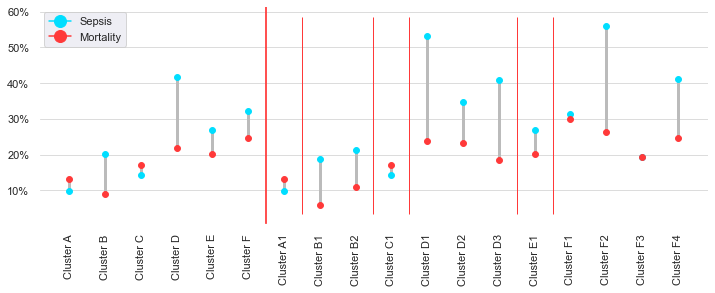

In [775]:
# create data
values_sep=np.append(prevalence_df[1].Sepsis.values,prevalence_df[0].Sepsis.values)
values_mor=np.append(prevalence_df[1].Mortality.values,prevalence_df[0].Mortality.values)
indexes=np.append(prevalence_df[1].index,prevalence_df[0].index)

# Set fonts
font_path='/Users/valerio/Library/Fonts/Lato-Black.ttf'
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()

# Set colours
sepsis_colour='#00DEFF'
mortality_colour='#ff3939'

fig, ax = plt.subplots(figsize=(12,4))
sns.set(font_scale = 1)

ax.yaxis.grid(True, color='#BBBBBB', ls='-', lw=0.5, zorder=1)

import matplotlib.ticker as mtick
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

ax.set_facecolor('white')
plt.axvline(x = 5.5, color = '#ff3939', linewidth='1.75' ,linestyle = '-', zorder=2)
#plt.axhline(y = 0, color = '#BBBBBB', linewidth='2' ,linestyle = '-', zorder=1)

#plt.vlines(x = [6.5, 8.5, 9.5, 12.5, 13.5], color = '#ff3939', linewidth='0.75' ,linestyle = '-', zorder=2)
#ax2.hlines([1, 3, 4, 7, 8], *ax.get_xlim(), **{'linewidth':5})

plt.vlines(x=indexes, ymin=values_sep, ymax=values_mor, color='#BBBBBB',linewidth=3, alpha =1, zorder=3)
#plt.vlines(x=indexes, ymin=0, ymax=values_sep, color='#BBBBBB',linewidth=3, alpha =1, zorder=3)
plt.scatter(x=indexes, y=values_sep, color=sepsis_colour, alpha=1, zorder=10, s=35)
plt.scatter(x=indexes, y=values_mor, color=mortality_colour, alpha=1, zorder=10, s=35)

ax.vlines([6.5, 8.5, 9.5, 12.5, 13.5], colors="#ff3939", *ax.get_ylim(), **{'linewidth':1})


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color=sepsis_colour, label='Sepsis',
                          markerfacecolor=sepsis_colour, markersize=12),
                   Line2D([0], [0], marker='o', color=mortality_colour, label='Mortality',
                          markerfacecolor=mortality_colour, markersize=12)]
ax.legend(handles=legend_elements, loc=2)

#plt.xticks(rotation=90)
labels_0 = df_complete.sort_values(['Level 0 membership'])['Level 0 membership'].unique()
labels_1 = df_complete.sort_values(['Level 1 membership'])['Level 1 membership'].unique()
ax.set_xticklabels(list(labels_1)+list(labels_0),rotation=90)
#plt.savefig('./Figures/sepsis_mortality_prevalence.eps',format='eps', bbox_inches = "tight")
plt.show()

In [769]:
set(df_complete['Level 1 membership'].values)
df_complete.sort_values(['Level 0 membership'])['Level 0 membership'].unique()

array(['Cluster A1', 'Cluster B1', 'Cluster B2', 'Cluster C1',
       'Cluster D1', 'Cluster D2', 'Cluster D3', 'Cluster E1',
       'Cluster F1', 'Cluster F2', 'Cluster F3', 'Cluster F4'],
      dtype=object)

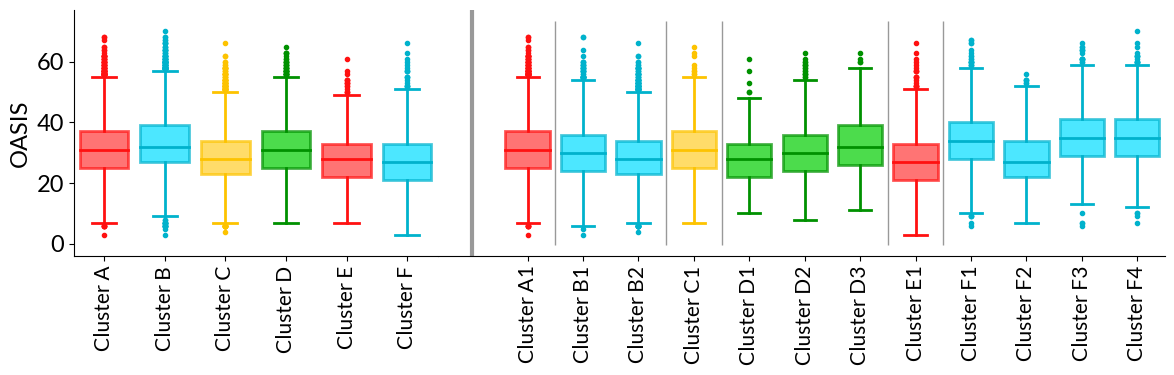

In [874]:
import matplotlib.colors as mc
import colorsys
import seaborn as sns

def lighten_color(color, amount=0.5):  
    # --------------------- SOURCE: @IanHincks ---------------------
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

# --------------------- SOURCE: @tmdavison ---------------------    
# Set fonts
font_path='/Users/valerio/Library/Fonts/Lato-Black.ttf'
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()
plt.rcParams.update({'font.size': 15})


fig=plt.figure(figsize=(12,4))
gs = fig.add_gridspec(1, 2, hspace=0, wspace=0,width_ratios=[6,12])
(ax1, ax2)= gs.subplots(sharex='col', sharey='row')

#fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,6))                           
flierprops = dict(marker='o', markersize=3)
ax2.set_facecolor('white')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(True)
ax1.set_facecolor('white')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_visible(True)

palette_0 = ["#ff3939","#00deff","#00deff", "#ffce29","#00ce00","#00ce00","#00ce00","#ff3939","#00deff","#00deff","#00deff","#00deff"]

linewidth=2

labels_0 = df_complete.sort_values(['Level 0 membership'])['Level 0 membership'].unique()
labels_1 = df_complete.sort_values(['Level 1 membership'])['Level 1 membership'].unique()


sns.boxplot(x="Level 1 membership", y="oasis", data=df_complete, palette=palette, saturation=1, 
            flierprops=flierprops, ax=ax1, linewidth=linewidth,boxprops=dict(alpha=.7))
sns.boxplot(x="Level 0 membership", y="oasis", data=df_complete, palette=palette_0, saturation=1, 
            flierprops=flierprops, ax=ax2, linewidth=linewidth,boxprops=dict(alpha=.7))

for i,artist in enumerate(ax2.artists):
    # Set the linecolor on the artist to the facecolor, and set the facecolor to None
    col = lighten_color(artist.get_facecolor(), 1.2)
    artist.set_edgecolor(col)    

    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same colour as above
    for j in range(i*6,i*6+6):
        line = ax2.lines[j]
        line.set_color(col)
        line.set_mfc(col)
        line.set_mec(col)
        line.set_linewidth(linewidth)   # ADDITIONAL ADJUSTMENT

for i,artist in enumerate(ax1.artists):
    # Set the linecolor on the artist to the facecolor, and set the facecolor to None
    col = lighten_color(artist.get_facecolor(), 1.2)
    artist.set_edgecolor(col)    

    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same colour as above
    for j in range(i*6,i*6+6):
        line = ax1.lines[j]
        line.set_color(col)
        line.set_mfc(col)
        line.set_mec(col)
        line.set_linewidth(linewidth)   # ADDITIONAL ADJUSTMENT

plt.axvline(x = -1, color = '#999999', linewidth='3' ,linestyle = '-', zorder=2)
ax2.vlines([0.5, 2.5, 3.5, 6.5, 7.5],  color='#999999', *ax2.get_ylim(), **{'linewidth':1})

ax1.set_ylabel('OASIS',fontsize=17)
ax2.set_ylabel('')
ax2.set_xlabel('')
ax1.set_xlabel('')

ax2.tick_params(left=False)

labels_0 = df_complete.sort_values(['Level 0 membership'])['Level 0 membership'].unique()
labels_1 = df_complete.sort_values(['Level 1 membership'])['Level 1 membership'].unique()
ax1.set_xticklabels(labels_1,rotation=90,fontsize=15)
ax2.set_xticklabels(labels_0,rotation=90,fontsize=15)
plt.setp(ax1.get_yticklabels(), fontsize=17)


plt.tight_layout()
#plt.savefig('./Figures/oasis_boxplot_short.pdf',format='pdf', bbox_inches = "tight")
plt.show()

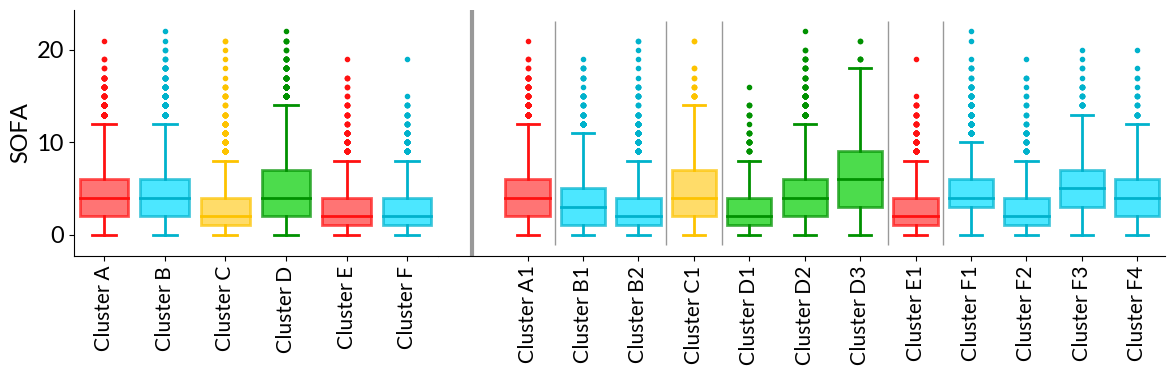

In [873]:
import matplotlib.colors as mc
import colorsys
import seaborn as sns

def lighten_color(color, amount=0.5):  
    # --------------------- SOURCE: @IanHincks ---------------------
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

# --------------------- SOURCE: @tmdavison ---------------------    
# Set fonts
font_path='/Users/valerio/Library/Fonts/Lato-Black.ttf'
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()
plt.rcParams.update({'font.size': 15})


fig=plt.figure(figsize=(12,4))
gs = fig.add_gridspec(1, 2, hspace=0, wspace=0,width_ratios=[6,12])
(ax1, ax2)= gs.subplots(sharex='col', sharey='row')

flierprops = dict(marker='o', markersize=3)
ax2.set_facecolor('white')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(True)
ax1.set_facecolor('white')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_visible(True)

palette_0 = ["#ff3939","#00deff","#00deff", "#ffce29","#00ce00","#00ce00","#00ce00","#ff3939","#00deff","#00deff","#00deff","#00deff"]

linewidth=2

labels_0 = df_complete.sort_values(['Level 0 membership'])['Level 0 membership'].unique()
labels_1 = df_complete.sort_values(['Level 1 membership'])['Level 1 membership'].unique()


sns.boxplot(x="Level 1 membership", y="sofa", data=df_complete, palette=palette, saturation=1, 
            flierprops=flierprops, ax=ax1, linewidth=linewidth,boxprops=dict(alpha=.7))
sns.boxplot(x="Level 0 membership", y="sofa", data=df_complete, palette=palette_0, saturation=1, 
            flierprops=flierprops, ax=ax2, linewidth=linewidth,boxprops=dict(alpha=.7))

for i,artist in enumerate(ax2.artists):
    # Set the linecolor on the artist to the facecolor, and set the facecolor to None
    col = lighten_color(artist.get_facecolor(), 1.2)
    artist.set_edgecolor(col)    

    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same colour as above
    for j in range(i*6,i*6+6):
        line = ax2.lines[j]
        line.set_color(col)
        line.set_mfc(col)
        line.set_mec(col)
        line.set_linewidth(linewidth)   # ADDITIONAL ADJUSTMENT

for i,artist in enumerate(ax1.artists):
    # Set the linecolor on the artist to the facecolor, and set the facecolor to None
    col = lighten_color(artist.get_facecolor(), 1.2)
    artist.set_edgecolor(col)    

    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same colour as above
    for j in range(i*6,i*6+6):
        line = ax1.lines[j]
        line.set_color(col)
        line.set_mfc(col)
        line.set_mec(col)
        line.set_linewidth(linewidth)   # ADDITIONAL ADJUSTMENT

plt.axvline(x = -1, color = '#999999', linewidth='3' ,linestyle = '-', zorder=2)
ax2.vlines([0.5, 2.5, 3.5, 6.5, 7.5],  color='#999999', *ax2.get_ylim(), **{'linewidth':1})

ax1.set_ylabel('SOFA', fontsize=17)
ax2.set_ylabel('')
ax2.set_xlabel('')
ax1.set_xlabel('')

ax2.tick_params(left=False)

labels_0 = df_complete.sort_values(['Level 0 membership'])['Level 0 membership'].unique()
labels_1 = df_complete.sort_values(['Level 1 membership'])['Level 1 membership'].unique()
ax1.set_xticklabels(labels_1,rotation=90,fontsize=15)
ax2.set_xticklabels(labels_0,rotation=90,fontsize=15)
plt.setp(ax1.get_yticklabels(), fontsize=17)



plt.tight_layout()
plt.savefig('./Figures/sofa_boxplot_short.pdf',format='pdf', bbox_inches = "tight")
plt.show()

In [828]:
df_morbidity_count=df_complete[['Level 1 membership','Level 0 membership']]
df_morbidity_count['Morbidities']=df_complete[['congestive_heart_failure', 'cardiac_arrhythmias', 'valvular_disease', 'pulmonary_circulation', 'peripheral_vascular', 
                       'hypertension','paralysis', 'other_neurological', 'chronic_pulmonary', 
                       'diabetes_uncomplicated', 'diabetes_complicated', 'hypothyroidism','renal_failure', 
                       'liver_disease', 'peptic_ulcer', 'aids', 'lymphoma','metastatic_cancer', 'solid_tumor', 
                       'rheumatoid_arthritis','coagulopathy', 'obesity', 'weight_loss', 'fluid_electrolyte',
                       'blood_loss_anemia', 'deficiency_anemias', 'alcohol_abuse', 'drug_abuse', 'psychoses', 
                       'depression']].sum(axis=1).astype(int)

/var/folders/fq/wt1x9tfs2nd53vf0mvvhmnjc0000gn/T/ipykernel_14139/1590946486.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_morbidity_count['Morbidities']=df_complete[['congestive_heart_failure', 'cardiac_arrhythmias', 'valvular_disease', 'pulmonary_circulation', 'peripheral_vascular',


In [829]:
df_morbidity_count.head(3)

Level 1 membership Level 0 membership  Morbidities
hadm_id                                                   
100001           Cluster E         Cluster E1            3
100003           Cluster F         Cluster F3            2
100006           Cluster E         Cluster E1            4

In [927]:
D3=df_complete[df_complete['Level 0 membership']=='Cluster D3']

In [937]:
D3['Level 1 membership']

hadm_id
100009    Cluster D
100018    Cluster D
100035    Cluster D
100087    Cluster D
100210    Cluster D
            ...    
199584    Cluster D
199675    Cluster D
199757    Cluster D
199951    Cluster D
199955    Cluster D
Name: Level 1 membership, Length: 1658, dtype: object

In [947]:
ages=['16-24','25-44','45-64','65-84','over85']
df_complete.groupby('Level 1 membership')[ages].mean()/df_complete[ages].mean()-1

16-24     25-44     45-64     65-84    over85
Level 1 membership                                                  
Cluster A           4.158075  1.718663  0.080861 -0.629287 -0.804037
Cluster B           6.532558  5.706195 -1.000000 -1.000000 -1.000000
Cluster C          -0.290052 -0.166747  0.361552 -0.118343 -0.377150
Cluster D           0.072786  0.976260  1.236069 -1.000000 -1.000000
Cluster E          -0.930912 -0.593072 -0.023887  0.534873 -1.000000
Cluster F          -1.000000 -1.000000 -0.407331  0.279307  1.447249

In [951]:
df_complete.groupby('Level 1 membership')['sepsis'].mean()

Level 1 membership
Cluster A    0.096834
Cluster B    0.201204
Cluster C    0.142568
Cluster D    0.416495
Cluster E    0.270276
Cluster F    0.320911
Name: sepsis, dtype: float64

In [952]:
df_complete.sepsis.mean()

0.2752427310825936

In [957]:
sepsis_df.groupby('Level 0 membership')['mortality'].mean()

Level 0 membership
1     0.133080
2     0.058065
3     0.109756
4     0.170213
5     0.238304
6     0.231928
7     0.184638
8     0.202982
9     0.298377
10    0.262870
11    0.194690
12    0.247093
Name: mortality, dtype: float64

In [1001]:
field='mortality'
print(df_complete[field].mean())
print(df_complete.groupby('Level 0 membership')[field].mean())
print(df_complete.groupby('Level 0 membership')[field].mean()/df_complete[field].mean()-1)

0.11416820678345524
Level 0 membership
Cluster A1    0.060751
Cluster B1    0.038508
Cluster B2    0.050775
Cluster C1    0.082508
Cluster D1    0.168740
Cluster D2    0.127737
Cluster D3    0.106755
Cluster E1    0.103936
Cluster F1    0.212999
Cluster F2    0.201598
Cluster F3    0.087521
Cluster F4    0.165354
Name: mortality, dtype: float64
Level 0 membership
Cluster A1   -0.467881
Cluster B1   -0.662710
Cluster B2   -0.555266
Cluster C1   -0.277316
Cluster D1    0.477997
Cluster D2    0.118851
Cluster D3   -0.064931
Cluster E1   -0.089621
Cluster F1    0.865661
Cluster F2    0.765798
Cluster F3   -0.233400
Cluster F4    0.448340
Name: mortality, dtype: float64


In [995]:
for i in df_complete.groupby('Level 0 membership').diagnosis.agg(lambda x:x.value_counts().index[:5]):
    print(i)

['S/P MOTOR VEHICLE ACCIDENT' 'S/P FALL' 'BLUNT TRAUMA'
 'SUBARACHNOID HEMORRHAGE' 'INTRACRANIAL HEMORRHAGE']
['S/P MOTOR VEHICLE ACCIDENT' 'DIABETIC KETOACIDOSIS' 'S/P FALL'
 'BLUNT TRAUMA' 'OVERDOSE']
['OVERDOSE' 'DIABETIC KETOACIDOSIS' 'ALTERED MENTAL STATUS' 'PNEUMONIA'
 'SEPSIS']
['CORONARY ARTERY DISEASE'
 'CORONARY ARTERY DISEASE\\CORONARY ARTERY BYPASS GRAFT /SDA'
 'INTRACRANIAL HEMORRHAGE' 'SUBARACHNOID HEMORRHAGE'
 'CORONARY ARTERY DISEASE\\CORONARY ARTERY BYPASS GRAFT/SDA']
['ALTERED MENTAL STATUS' 'LIVER FAILURE' 'PNEUMONIA' 'UPPER GI BLEED'
 'SEPSIS']
['ALTERED MENTAL STATUS' 'UPPER GI BLEED' 'GASTROINTESTINAL BLEED'
 'LIVER FAILURE' 'PNEUMONIA']
['CONGESTIVE HEART FAILURE' 'PNEUMONIA' 'CHEST PAIN' 'SEPSIS'
 'CORONARY ARTERY DISEASE']
['CORONARY ARTERY DISEASE' 'PNEUMONIA'
 'CORONARY ARTERY DISEASE\\CORONARY ARTERY BYPASS GRAFT /SDA' 'SEPSIS'
 'CHEST PAIN']
['PNEUMONIA' 'INTRACRANIAL HEMORRHAGE' 'SEPSIS' 'S/P FALL'
 'CONGESTIVE HEART FAILURE']
['PNEUMONIA' 'CONGESTIVE HEAR

In [976]:
df_complete.columns

Index(['congestive_heart_failure', 'cardiac_arrhythmias', 'valvular_disease',
       'pulmonary_circulation', 'peripheral_vascular', 'hypertension',
       'paralysis', 'other_neurological', 'chronic_pulmonary',
       'diabetes_uncomplicated', 'diabetes_complicated', 'hypothyroidism',
       'renal_failure', 'liver_disease', 'peptic_ulcer', 'aids', 'lymphoma',
       'metastatic_cancer', 'solid_tumor', 'rheumatoid_arthritis',
       'coagulopathy', 'obesity', 'weight_loss', 'fluid_electrolyte',
       'blood_loss_anemia', 'deficiency_anemias', 'alcohol_abuse',
       'drug_abuse', 'psychoses', 'depression', '16-24', '25-44', '45-64',
       '65-84', 'over85', 'F', 'M', 'ELECTIVE', 'NON_ELECTIVE', 'sepsis',
       'mortality', 'diagnosis', 'icustay_id', 'oasis', 'sofa',
       'Level 0 membership', 'Level 1 membership'],
      dtype='object')

In [1002]:
len(df_complete)

38417

In [1009]:
df_complete.groupby('Level 0 membership').mean()

congestive_heart_failure  cardiac_arrhythmias  \
Level 0 membership                                                  
Cluster A1                          0.000000             0.000000   
Cluster B1                          0.000000             0.000000   
Cluster B2                          0.042169             0.130809   
Cluster C1                          0.039434             0.115672   
Cluster D1                          0.140747             0.251166   
Cluster D2                          0.039625             0.091762   
Cluster D3                          0.530157             0.505428   
Cluster E1                          0.280298             0.425560   
Cluster F1                          0.351997             0.536022   
Cluster F2                          0.755378             0.781192   
Cluster F3                          0.102393             0.254530   
Cluster F4                          0.568122             0.657361   

                    valvular_disease  pulmonary_circulation  \
Level 0 membership                                            
Cluster A1                  0.000000               0.000000   
Cluster B1                  0.000000               0.016847   
Cluster B2                  0.028399               0.027539   
Cluster C1                  0.023256               0.005056   
Cluster D1                  0.040435               0.057543   
Cluster D2                  0.011470               0.025026   
Cluster D3                  0.226176               0.234620   
Cluster E1                  0.131315               0.048455   
Cluster F1                  0.134299               0.031323   
Cluster F2                  0.393977               0.309158   
Cluster F3                  0.053504               0.016068   
Cluster F4                  0.251253               0.127654   

                    peripheral_vascular  hypertension  paralysis  \
Level 0 membership                                                 
Cluster A1                     0.000000      0.000000   0.000000   
Cluster B1                     0.000000      0.000000   0.000000   
Cluster B2                     0.024096      0.185886   0.029260   
Cluster C1                     0.018605      0.365622   0.010111   
Cluster D1                     0.041991      0.544323   0.055210   
Cluster D2                     0.008863      0.229927   0.045360   
Cluster D3                     0.163450      0.776236   0.037998   
Cluster E1                     0.094018      0.670524   0.030892   
Cluster F1                     0.061472      0.648786   0.030932   
Cluster F2                     0.282114      0.872157   0.051014   
Cluster F3                     0.037265      0.534017   0.017436   
Cluster F4                     0.174660      0.796469   0.036507   

                    other_neurological  chronic_pulmonary  \
Level 0 membership                                          
Cluster A1                    0.000000           0.000000   
Cluster B1                    0.128761           0.000000   
Cluster B2                    0.117040           0.101549   
Cluster C1                    0.037209           0.062487   
Cluster D1                    0.318040           0.247278   
Cluster D2                    0.201251           0.117310   
Cluster D3                    0.150784           0.474668   
Cluster E1                    0.097841           0.233289   
Cluster F1                    0.090838           0.137431   
Cluster F2                    0.192379           0.580824   
Cluster F3                    0.069573           0.114188   
Cluster F4                    0.132665           0.400382   

                    diabetes_uncomplicated  ...    over85         F         M  \
Level 0 membership                          ...                                 
Cluster A1                        0.000000  ...  0.022459  0.380707  0.619293   
Cluster B1                        0.000000  ...  0.000000  0.369434  0.630566   
Cluster B2                        0.05

In [1010]:
df_complete.mean()

/var/folders/fq/wt1x9tfs2nd53vf0mvvhmnjc0000gn/T/ipykernel_14139/920591365.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_complete.mean()


congestive_heart_failure         0.239503
cardiac_arrhythmias              0.340058
valvular_disease                 0.109795
pulmonary_circulation            0.058906
peripheral_vascular              0.076477
hypertension                     0.533097
paralysis                        0.026577
other_neurological               0.102220
chronic_pulmonary                0.199313
diabetes_uncomplicated           0.192545
diabetes_complicated             0.054247
hypothyroidism                   0.094437
renal_failure                    0.120650
liver_disease                    0.090273
peptic_ulcer                     0.008226
aids                             0.005701
lymphoma                         0.012599
metastatic_cancer                0.053596
solid_tumor                      0.028060
rheumatoid_arthritis             0.030507
coagulopathy                     0.103105
obesity                          0.049457
weight_loss                      0.037249
fluid_electrolyte                0